In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import make_column_transformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [29]:
# AUROC values and curves
def plot_stats(cf_matrix, y_true, y_pred, title, axV=None):
    """

    :param cf_matrix: Confusion Matrix
    :param y_true: 
    :param y_pred:
    :return:
    """
    group_names = ['True 0','False 1','False 2','False 0','True 1','False 2','False 0','False 1','True 2']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    s1 = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axV)
    
    acc = np.trace(cf_matrix)/np.sum(cf_matrix)
    f1 = f1_score(y_true, y_pred, average=None)
    #aucroc = roc_auc_score(y_true, y_pred)
    #text = "Predicted Label\nAccuracy: {:.3f}\nF1 score: {:.3f}\nAUCROC: {:.3f}".format(acc,f1,aucroc)
    text = "Predicted Label\nAccuracy: {:.3f}\nF1 score:\n 0: {:.3f}, 1: {:.3f}, 2: {:.3f}\n".format(acc,*f1)
    
    s1.set_xlabel(text)
    s1.set_ylabel('Actual Label')
    s1.set_title(title)

def calc_vif(data, cols=None):
    if cols is None: cols = data.columns
    vif_df = pd.DataFrame()
    vif_df['VIF'] = [variance_inflation_factor(data[cols].values,i) for i in range(data[cols].shape[1])]
    vif_df['features'] = data[cols].columns
    return vif_df

def train_test_split(data, col_2_split, col_2_drop = [], output_cols=[], is_stratified = True):
    if is_stratified: # do stratified splitting
        sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

        for train_index, test_index in sss.split(data,data[col_2_split]):
            train_data, test_data = data.iloc[train_index,:], data.iloc[test_index,:]
    else:
        #ToDo
        pass
    
    y_train = train_data[output_cols]
    X_train = train_data.drop(labels=output_cols+col_2_drop, axis=1)
    y_test = test_data[output_cols]
    X_test = test_data.drop(labels=output_cols+col_2_drop, axis=1)
    
    return X_train, y_train, X_test, y_test

def standardize_data(train: pd.DataFrame, test: pd.DataFrame, 
                     cols_transform: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    scaler = StandardScaler()
    ct = make_column_transformer((scaler, cols_transform), remainder='drop')
    ct.fit(train)

    train_std: pd.DataFrame = ct.transform(train)
    train_std: pd.DataFrame = pd.DataFrame(train_std, 
                                           columns=cols_transform,
                                           index=train.index)

    test_std: pd.DataFrame = ct.transform(test)
    test_std: pd.DataFrame = pd.DataFrame(test_std,
                                          columns=cols_transform,
                                          index=test.index)

    cols_remainder: List[str] = list(set(train.columns) - set(train_std.columns))

    for col in cols_remainder:
        train_std.loc[:,col] = train.loc[:,col]
        test_std.loc[:,col] = test.loc[:,col]
    
    return train_std, test_std

def find_data_mismatch(test, pred, pred_label, actual_label):
    return test[test[pred==pred_label]==actual_label].dropna().index

## Read all the csvs and separate into individual cylinder and save in output file

In [48]:
# define constants
INPUT_DATA_PATH = '..\\input\\'
OUTPUT_DATA_PATH = '..\\output\\'

# define columns
FILE_COLS = ['FileName']
MAP_COLS = ['MAP_Intake_30', 'MAP_Intake_60', 'MAP_Intake_90', 'MAP_Intake_120', 'MAP_Intake_150','MAP_Intake_180']
CAINTAKE_COLS = ['CrkAccel_Intake_30', 'CrkAccel_Intake_60', 'CrkAccel_Intake_90','CrkAccel_Intake_120', 
                         'CrkAccel_Intake_150', 'CrkAccel_Intake_180']
CACOMPRESS_COLS = ['CrkAccel_Compress_30', 'CrkAccel_Compress_60', 'CrkAccel_Compress_90','CrkAccel_Compress_120', 
                   'CrkAccel_Compress_150','CrkAccel_Compress_180']
CAEXPANSION_COLS = ['CrkAccel_Expansion_30','CrkAccel_Expansion_60', 'CrkAccel_Expansion_90','CrkAccel_Expansion_120', 
                    'CrkAccel_Expansion_150','CrkAccel_Expansion_180']
COMMON_COLS = ['MAF', 'NetTQ', 'IntCam', 'ExhCam', 'RPM']
CA_6DEG_COLS = ['CrkAccel6deg_Compress_30', 'CrkAccel6deg_Compress_60', 'CrkAccel6deg_Compress_90', 
                'CrkAccel6deg_Compress_120', 'CrkAccel6deg_Compress_150', 'CrkAccel6deg_Compress_180',
                'CrkAccel6deg_Expansion_30', 'CrkAccel6deg_Expansion_60', 'CrkAccel6deg_Expansion_90', 
                'CrkAccel6deg_Expansion_120', 'CrkAccel6deg_Expansion_150', 'CrkAccel6deg_Expansion_180']
FF_COLS = ['FF', 'HF']
CAT_COLS = ['CylStatusPrev', 'CylStatusNext']
CAT_CYL_COLS = ['CylIntEnbNext', 'CylIntEnb', 'CylIntEnbBasePrev', 'CylIntEnbBaseNext', 'CylIntEnbBase', 'CylExhEnbPrev',
                'CylExhEnbNext', 'CylExhEnb', 'CylExhEnbBasePrev','CylExhEnbBaseNext', 'CylExhEnbBase']
OUTPUT_COLS = ['CylStatus']

In [14]:
files = os.listdir(os.path.join(INPUT_DATA_PATH))

# get all the data
# all_data_df = pd.concat([pd.read_csv(os.path.join(INPUT_DATA_PATH, f)) for f in files if f[-3:]=='csv'], 
#                         ignore_index=True)

a=[]
for f in files:
    if f[-3:] != 'csv': continue
    if f == 'TA20060_A317.csv':
        print('ignoring: ', f)
        continue
    
    data = pd.read_csv(os.path.join(INPUT_DATA_PATH, f))
    data.loc[:,'FileName'] = f[:-4]
    a.append(data)
all_data_df = pd.concat(a, ignore_index=True)
#get specific cyl data and save to csv
for cyl in [1,2,3,4]:
    all_data_df[all_data_df.loc[:, 'ActiveCylID'] == cyl].to_csv(os.path.join(OUTPUT_DATA_PATH, 
                                                                              'Data_Cyl_{}.csv'.format(cyl)),
                                                                 index=False)
del a

ignoring:  TA20060_A317.csv


# Data Exploration

In [4]:
# Start with cylinder 1 data exploration
# Try to modularize s.t. functions can be reused for rest cylinders than DRY

all_cyl_1_data = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, 'Data_Cyl_1.csv'))
print('Cyl 1 shape before:', all_cyl_1_data.shape)
cyl_1_data = all_cyl_1_data.drop(columns=['ActiveCylID']+FILE_COLS)
cyl_1_data.dropna(inplace=True)
print(cyl_1_data.info())

Cyl 1 shape before: (51279, 36)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51279 entries, 0 to 51278
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CylStatusPrev           51279 non-null  int64  
 1   CylStatusNext           51279 non-null  int64  
 2   CylStatus               51279 non-null  int64  
 3   MAP_Intake_30           51279 non-null  float64
 4   MAP_Intake_60           51279 non-null  float64
 5   MAP_Intake_90           51279 non-null  float64
 6   MAP_Intake_120          51279 non-null  float64
 7   MAP_Intake_150          51279 non-null  float64
 8   MAP_Intake_180          51279 non-null  float64
 9   MAF                     51279 non-null  float64
 10  NetTQ                   51279 non-null  float64
 11  IntCam                  51279 non-null  float64
 12  ExhCam                  51279 non-null  float64
 13  RPM                     51279 non-null  float64
 14  FF    

In [5]:
cyl_1_data.describe()['FF']

count    51279.000000
mean         0.693781
std          0.170315
min          0.333300
25%          0.500000
50%          0.666700
75%          0.800000
max          1.000000
Name: FF, dtype: float64

In [ ]:
cyl_1_data.head()

2    18682
1    16482
0    16115
Name: CylStatus, dtype: int64


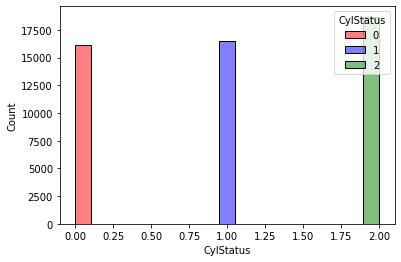

In [6]:
# Output class distribution
print(cyl_1_data['CylStatus'].value_counts())
sns.histplot(x='CylStatus', data=cyl_1_data, hue=cyl_1_data['CylStatus'], palette=['r','b','g'])
plt.show()

The output class seems to be equally distributed. So not the issue of class imbalance.

### Explore FFs and HFs

- FF's define what fraction of the cylinders are active 
- HS defines of the activated cylinders what fraction are High fires

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=cyl_1_data, x='FF', hue='CylStatus', multiple='stack', palette=['r','b','g'])
plt.show()

In [7]:
display(cyl_1_data['FF'].value_counts())
display(cyl_1_data['HF'].value_counts())

0.6667    15177
0.5000    10426
0.8000     9962
1.0000     6815
0.7500     5546
0.4000     2747
0.3333      606
Name: FF, dtype: int64

0.5000    14995
0.0000    14829
1.0000     9830
0.7500     7684
0.6667     2847
0.3333     1094
Name: HF, dtype: int64

*Need to remove the single count of the FFs and HFs*

As of 1/22/2021, this dataset has fixed fraction data issues, drop them.

In [8]:
cyl_1_data = cyl_1_data[~np.isclose(cyl_1_data['FF'], 0.5)]
cyl_1_data = cyl_1_data[~np.isclose(cyl_1_data['FF'], 0.75)]
cyl_1_data = cyl_1_data[~np.isclose(cyl_1_data['FF'], 0.25)]
print('Shape after removing fixed FF', cyl_1_data.shape)
display(cyl_1_data['FF'].value_counts())
display(cyl_1_data['HF'].value_counts())

Shape after removing fixed FF (35307, 34)


0.6667    15177
0.8000     9962
1.0000     6815
0.4000     2747
0.3333      606
Name: FF, dtype: int64

0.0000    11987
0.5000    11689
1.0000     6204
0.7500     3117
0.6667     1216
0.3333     1094
Name: HF, dtype: int64

In [9]:
# Remove the ffs and hfs
remove_FFs = list(cyl_1_data['FF'].value_counts()[cyl_1_data['FF'].value_counts()<2].index.values)
remove_HFs = list(cyl_1_data['HF'].value_counts()[cyl_1_data['HF'].value_counts()<2].index.values)
cyl_1_data_remove_FF_HF = cyl_1_data[~cyl_1_data.FF.isin(remove_FFs+remove_HFs)]
print(cyl_1_data_remove_FF_HF.shape)

(35307, 34)


1    14282
2    11909
0     9116
Name: CylStatus, dtype: int64


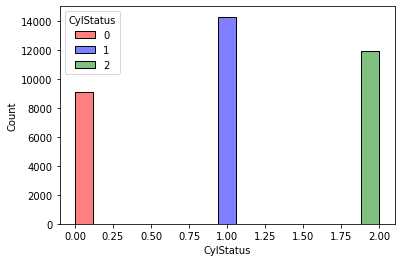

In [21]:
print(cyl_1_data_remove_FF_HF['CylStatus'].value_counts())
sns.histplot(x='CylStatus', data=cyl_1_data, hue=cyl_1_data_remove_FF_HF['CylStatus'], palette=['r','b','g'])
plt.show()

## RPMs

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=cyl_1_data_remove_FF_HF, x='RPM', hue='CylStatus', multiple='stack', palette=['r','b','g'])
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
sns.histplot(data=cyl_1_data_remove_FF_HF,x='RPM', binwidth=100, kde=True)
plt.show()

In [ ]:
cyl_1_data_remove_FF_HF['RPM'].describe()

In [ ]:
pd.cut(cyl_1_data_remove_FF_HF['RPM'],bins=14).value_counts(ascending=True)

In [ ]:
a=pd.cut(cyl_1_data_remove_FF_HF['RPM'],bins=14).value_counts()
plt.figure(figsize=(10,7))
by_rpm=sns.barplot(x=a.index,y=a.values)
#by_rpm.set_xticklabels(by_rpm.get_xticklabels(), rotation=30)
for item in by_rpm.get_xticklabels():
    item.set_rotation(90)

In [ ]:
_, rpm_ranges = pd.cut(cyl_1_data_remove_FF_HF['RPM'],bins=14,retbins=True)

In [ ]:
plt.figure(figsize=(10,7))
g=sns.histplot(data=cyl_1_data_remove_FF_HF,x='RPM', bins=rpm_ranges, hue='CylStatus',palette=['r','b','g'],multiple='stack')
#g.legend(loc='upper left')
#plt.legend(loc='upper left')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Drop the lower rpms? 

## Intake Manifold

In [ ]:
cyl_1_data_remove_FF_HF.groupby('CylStatus').mean()[MAP_COLS]

Makes sense as when both the intake valves are opened, the pressure drops in the intake manifolds

In [ ]:
# Add FF in the mix
grouped = cyl_1_data.groupby(['CylStatus', 'FF']).mean()[MAP_COLS].reset_index()
grouped

In [ ]:
cyl_1_data_remove_FF_HF.groupby(['CylStatus', 'FF','HF']).mean()[MAP_COLS]

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=cyl_1_data_remove_FF_HF[MAP_COLS])
plt.show()

Correlations between the variables

In [ ]:
sns.pairplot(data=cyl_1_data_remove_FF_HF[MAP_COLS])

## CrankAccel

In [ ]:
sns.lineplot(data=cyl_1_data_remove_FF_HF, x='FF',y='CrkAccel_Intake_30',hue='CylStatus', palette=['r','b','g'])

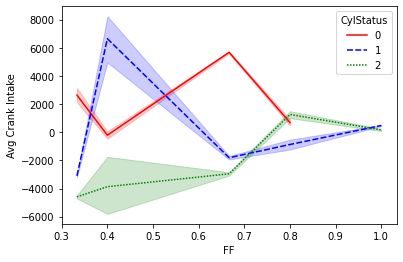

In [14]:
sns.lineplot(data=cyl_1_data_remove_FF_HF, x='FF',y=cyl_1_data_remove_FF_HF[CAINTAKE_COLS].mean(axis=1),
             hue='CylStatus', palette=['r','b','g'], style='CylStatus')
plt.ylabel('Avg Crank Intake')
plt.show()

In [ ]:
sns.lineplot(data=cyl_1_data_remove_FF_HF, x='FF',y=cyl_1_data_remove_FF_HF[CACOMPRESS_COLS].mean(axis=1),
             hue='CylStatus', palette=['r','b','g'], style='CylStatus')
plt.ylabel('Avg Crank Compress')
plt.show()

In [ ]:
sns.lineplot(data=cyl_1_data_remove_FF_HF, x='FF',y=cyl_1_data_remove_FF_HF[CAEXPANSION_COLS].mean(axis=1),
             hue='CylStatus', palette=['r','b','g'], style='CylStatus')
plt.ylabel('Avg Crank Expansion')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=cyl_1_data_remove_FF_HF[CAEXPANSION_COLS])
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=cyl_1_data_remove_FF_HF[CAINTAKE_COLS])
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=cyl_1_data_remove_FF_HF[CACOMPRESS_COLS])
plt.show()

### Compression

In [ ]:
sns.histplot(cyl_1_data_remove_FF_HF['CrkAccel_Compress_30'],kde=True)
plt.show()

In [ ]:
cyl_1_data_remove_FF_HF[CACOMPRESS_COLS].describe()

In [ ]:
for cols in CACOMPRESS_COLS:
    print(pd.cut(cyl_1_data_remove_FF_HF[cols],10).value_counts())
    print('-'*100)

In [15]:
for cols in CACOMPRESS_COLS:
    display(cyl_1_data_remove_FF_HF[cyl_1_data_remove_FF_HF.loc[:,cols]<=-30000][COMMON_COLS+CAT_COLS
                                                                                        +OUTPUT_COLS+FF_COLS
                                                                                        +[cols]])

MAF       NetTQ     IntCam     ExhCam          RPM  \
19227  19.115313  106.648413  49.343107  15.401781  1999.743508   
19232  19.021702  106.402183  49.533078  15.551105  1983.946714   
19237  19.422061  106.436782  49.653765  15.548657  2005.826247   
19327  19.247441  106.731409  49.268127  15.550463  2012.920332   
19382  20.438503  112.688003  50.210554  15.521859  2006.896149   
19387  20.641819  112.860280  50.077260  15.369921  2041.275791   
19397  20.351235  112.609798  50.129321  15.590504  2034.552381   
19432  20.463881  112.513537  50.125540  15.425726  2000.873691   
19442  20.575415  113.193687  49.837992  15.600817  2010.678414   
19482  20.515738  112.642473  50.123475  15.453859  1984.930459   
19487  20.303480  112.507307  50.113103  15.480597  1997.701558   
19492  20.442628  113.012952  49.780335  15.836721  1979.986699   
19497  20.460238  112.658090  49.975284  15.503534  2022.742283   
19502  20.490378  112.342585  50.259936  15.616282  2030.165184   
19512  20.553289  112.424277  50.293502  15.398615  2042.902823   

       CylStatusPrev  CylStatusNext  CylStatus   FF   HF  CrkAccel_Compress_30  
19227              0              2          2  0.8  1.0         -30728.608833  
19232              0              2          2  0.8  1.0         -30916.458825  
19237              0              2          2  0.8  1.0         -31409.319593  
19327              0              2          2  0.8  1.0         -30218.900933  
19382              0              2          2  0.8  1.0         -32472.236651  
19387              0              2          2  0.8  1.0         -30717.871149  
19397              0              2          2  0.8  1.0         -30635.433338  
19432              0              2          2  0.8  1.0         -30100.082184  
19442              0              2          2  0.8  1.0         -30017.903524  
19482              0              2          2  0.8  1.0         -32152.667806  
19487              0              2          2  0.8  1.0         -33729.412337  
19492              0              2          2  0.8  1.0         -33266.716826  
19497              0              2          2  0.8  1.0         -30760.207993  
19502              0              2          2  0.8  1.0         -30328.533343  
19512              0              2          2  0.8  1.0         -30861.448758

MAF       NetTQ     IntCam     ExhCam          RPM  \
19169  18.251573   99.309656  48.039221  15.607746  2013.604138   
19222  19.094395  106.642960  49.526087  15.253715  2000.753020   
19227  19.115313  106.648413  49.343107  15.401781  1999.743508   
19232  19.021702  106.402183  49.533078  15.551105  1983.946714   
19237  19.422061  106.436782  49.653765  15.548657  2005.826247   
19242  19.148767  106.749519  49.428425  15.651535  2017.106011   
19247  19.329510  106.444662  49.578161  15.527289  2024.195637   
19262  19.341449  106.475607  49.647100  15.492010  2027.648157   
19282  19.445180  106.130390  49.880786  15.584760  2025.224992   
19292  19.271272  106.045621  49.677113  15.409168  2027.924878   
19302  19.265912  106.232695  49.807105  15.660033  2028.998272   
19312  19.119303  106.438993  49.757266  15.489679  2019.628409   
19317  19.311800  106.272124  49.578492  15.555341  2003.947599   
19322  19.223110  106.181073  49.760618  15.503240  1986.463428   
19327  19.247441  106.731409  49.268127  15.550463  2012.920332   
19332  19.260163  106.404776  49.685640  15.562216  2012.884017   
19337  19.597434  106.245794  49.847456  15.682857  2020.447063   
19342  19.191829  106.717130  49.532045  15.689848  2024.763417   
19352  19.428014  106.292878  49.878634  15.523552  2034.794361   
19367  19.298373  106.138416  49.970681  15.587827  2037.199135   
19377  19.243209  106.310904  49.968241  15.506678  2001.261601   
19382  20.438503  112.688003  50.210554  15.521859  2006.896149   
19387  20.641819  112.860280  50.077260  15.369921  2041.275791   
19392  20.671355  112.385533  50.445565  15.560348  2018.064290   
19397  20.351235  112.609798  50.129321  15.590504  2034.552381   
19402  20.264630  112.278202  50.429086  15.422131  2045.723553   
19432  20.463881  112.513537  50.125540  15.425726  2000.873691   
19437  20.526387  112.328583  50.264520  15.515073  2013.441098   
19442  20.575415  113.193687  49.837992  15.600817  2010.678414   
19447  20.504146  112.778703  50.133423  15.496389  2038.961949   
19452  20.267384  112.489635  50.239427  15.461215  2044.432552   
19472  20.619002  111.852698  50.574283  15.391987  2044.301267   
19477  20.799977  112.240614  50.405902  15.523274  2022.600807   
19482  20.515738  112.642473  50.123475  15.453859  1984.930459   
19487  20.303480  112.507307  50.113103  15.480597  1997.701558   
19492  20.442628  113.012952  49.780335  15.836721  1979.986699   
19497  20.460238  112.658090  49.975284  15.503534  2022.742283   
19502  20.490378  112.342585  50.259936  15.616282  2030.165184   
19507  20.492252  112.837300  50.073883  15.587072  2008.674273   
19512  20.553289  112.424277  50.293502  15.398615  2042.902823   
19517  20.252591  112.315844  50.397494  15.687044  2040.427470   
19522  20.514985  112.295745  50.252662  15.550497  2012.133931   
19527  20.645186  112.869950  49.891391  15.478190  2035.369583   
19532  20.707568  113.121527  49.853301  15.495356  2033.103388   
19537  20.485307  112.636647  50.294180  15.463464  2040.056010   
21011  17.521361  102.638621  36.857335  11.806640  2024.029027   
21111  17.822578  102.920302  36.741932  11.780006  2027.693064   
21116  18.136707  102.301661  36.940148  11.532340  2037.496431   
21159  17.956822  106.734710  35.298844  12.535012  2042.761389   
21184  18.121029  106.808540  35.220368  12.481079  2041.118942   
21214  18.160915  107.020934  35.200269  12.257263  2024.072105   

       CylStatusPrev  CylStatusNext  CylStatus   FF   HF  CrkAccel_Compress_60  
19169              0              2          2  0.8  1.0         -30143.718306  
19222              0              2          2  0.8  1.0         -31133.228903  
19227              0              2          2  0.8  1.0         -32384.130168  
19232              0              2          2  0.8  1.0         -32787.250891  
19237              0              2          2  0.8  1.0         -32690.826590  
19242              0              2       

MAF       NetTQ     IntCam     ExhCam          RPM  \
15123  11.480670   70.775558  47.604724  14.454112  2197.853493   
15128  11.811652   70.767647  47.609583  14.590237  2190.665059   
15138  11.560006   70.545189  47.803867  14.531593  2198.101170   
19382  20.438503  112.688003  50.210554  15.521859  2006.896149   
19387  20.641819  112.860280  50.077260  15.369921  2041.275791   
19402  20.264630  112.278202  50.429086  15.422131  2045.723553   
19407  20.646889  112.918304  50.121205  15.475044  2051.179280   
19437  20.526387  112.328583  50.264520  15.515073  2013.441098   
19442  20.575415  113.193687  49.837992  15.600817  2010.678414   
19447  20.504146  112.778703  50.133423  15.496389  2038.961949   
19482  20.515738  112.642473  50.123475  15.453859  1984.930459   
19487  20.303480  112.507307  50.113103  15.480597  1997.701558   
19492  20.442628  113.012952  49.780335  15.836721  1979.986699   
19497  20.460238  112.658090  49.975284  15.503534  2022.742283   
19502  20.490378  112.342585  50.259936  15.616282  2030.165184   
19512  20.553289  112.424277  50.293502  15.398615  2042.902823   
19527  20.645186  112.869950  49.891391  15.478190  2035.369583   
19537  20.485307  112.636647  50.294180  15.463464  2040.056010   
21219  18.135114  106.745764  35.054383  12.478461  2051.414000   
21244  18.378837  106.784169  35.132252  12.469157  2042.010888   

       CylStatusPrev  CylStatusNext  CylStatus   FF   HF  CrkAccel_Compress_90  
15123              0              2          0  0.4  1.0         -30549.561295  
15128              0              2          0  0.4  1.0         -30086.673830  
15138              0              2          0  0.4  1.0         -30117.710350  
19382              0              2          2  0.8  1.0         -31593.043439  
19387              0              2          2  0.8  1.0         -30341.140505  
19402              0              2          2  0.8  1.0         -30352.777096  
19407              0              2          2  0.8  1.0         -30081.792661  
19437              0              2          2  0.8  1.0         -33821.384674  
19442              0              2          2  0.8  1.0         -31789.898777  
19447              0              2          2  0.8  1.0         -32535.402759  
19482              0              2          2  0.8  1.0         -30332.903129  
19487              0              2          2  0.8  1.0         -32126.560673  
19492              0              2          2  0.8  1.0         -32239.818219  
19497              0              2          2  0.8  1.0         -32246.632937  
19502              0              2          2  0.8  1.0         -31948.927870  
19512              0              2          2  0.8  1.0         -30271.113633  
19527              0              2          2  0.8  1.0         -30893.026868  
19537              0              2          2  0.8  1.0         -30402.772504  
21219              0              1          1  0.8  0.0         -30532.637952  
21244              0              1          1  0.8  0.0         -30018.183884

MAF      NetTQ     IntCam     ExhCam          RPM  CylStatusPrev  \
19497  20.460238  112.65809  49.975284  15.503534  2022.742283              0   

       CylStatusNext  CylStatus   FF   HF  CrkAccel_Compress_120  
19497              2          2  0.8  1.0          -30918.043891

Empty DataFrame
Columns: [MAF, NetTQ, IntCam, ExhCam, RPM, CylStatusPrev, CylStatusNext, CylStatus, FF, HF, CrkAccel_Compress_150]
Index: []

MAF       NetTQ     IntCam     ExhCam          RPM  \
19488  21.212253  117.963143  49.902764  15.282961  2254.365259   
19493  20.986966  118.133373  49.672672  15.308310  2251.659785   

       CylStatusPrev  CylStatusNext  CylStatus   FF   HF  \
19488              2              2          0  0.8  1.0   
19493              2              2          0  0.8  1.0   

       CrkAccel_Compress_180  
19488          -30029.275182  
19493          -30746.535983

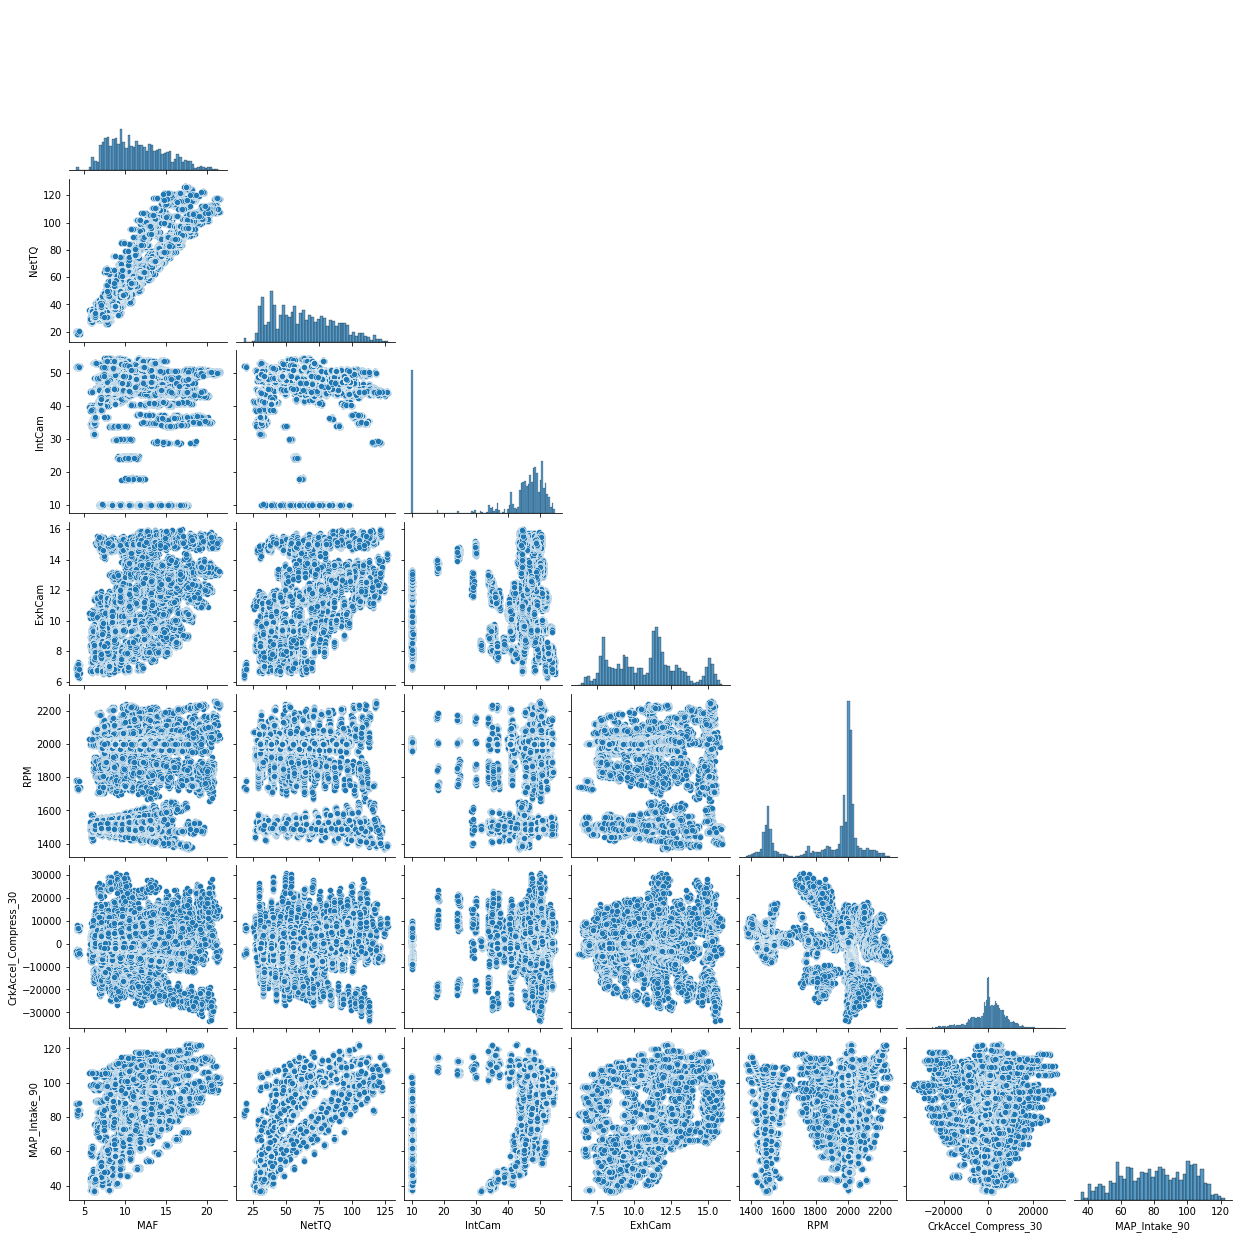

In [16]:
sns.pairplot(cyl_1_data_remove_FF_HF[COMMON_COLS+['CrkAccel_Compress_30','MAP_Intake_90']], corner=True)

Crank Accel compress < -40000 is quite rare. P(MAP_90;mean,sigma)xP(COMMON_COLS;mean,sigma) will be quite low and can be regarded as anomaly. Assuming there is no correlation between them and is diagonal. 

In [17]:
display(cyl_1_data_remove_FF_HF[cyl_1_data_remove_FF_HF.loc[:,'CrkAccel_Compress_180']<=-40000][COMMON_COLS+CAT_COLS
                                                                                        +OUTPUT_COLS+FF_COLS
                                                                                        +['CrkAccel_Compress_180',
                                                                                          'MAP_Intake_90']])

Empty DataFrame
Columns: [MAF, NetTQ, IntCam, ExhCam, RPM, CylStatusPrev, CylStatusNext, CylStatus, FF, HF, CrkAccel_Compress_180, MAP_Intake_90]
Index: []

Found an outlier. Remove it. Make a rule of data clean up like fixed fractions behavior on curr, next, prev.

In [ ]:
sns.pairplot(cyl_1_data_remove_FF_HF[(cyl_1_data_remove_FF_HF['FF']==0.8) & (cyl_1_data_remove_FF_HF['HF']==1.0)]
             [CACOMPRESS_COLS])

### Expansion

In [ ]:
sns.histplot(cyl_1_data_remove_FF_HF['CrkAccel_Expansion_30'],kde=True)
plt.show()

In [ ]:
for cols in CAEXPANSION_COLS:
    print(pd.cut(cyl_1_data_remove_FF_HF[cols],10).value_counts())
    print('-'*100)

In [19]:
display(cyl_1_data_remove_FF_HF[cyl_1_data_remove_FF_HF.loc[:,'CrkAccel_Expansion_30']<=-40000][COMMON_COLS+CAT_COLS
                                                                                        +OUTPUT_COLS+FF_COLS
                                                                                        +['CrkAccel_Expansion_30']])

Empty DataFrame
Columns: [MAF, NetTQ, IntCam, ExhCam, RPM, CylStatusPrev, CylStatusNext, CylStatus, FF, HF, CrkAccel_Expansion_30]
Index: []

Same point as found above.

In [18]:
display(cyl_1_data_remove_FF_HF[cyl_1_data_remove_FF_HF.loc[:,'CrkAccel_Expansion_180']>=40000][COMMON_COLS+CAT_COLS
                                                                                        +OUTPUT_COLS+FF_COLS
                                                                                        +['CrkAccel_Expansion_180','MAP_Intake_90']])

Empty DataFrame
Columns: [MAF, NetTQ, IntCam, ExhCam, RPM, CylStatusPrev, CylStatusNext, CylStatus, FF, HF, CrkAccel_Expansion_180, MAP_Intake_90]
Index: []

In [ ]:
sns.pairplot(cyl_1_data_remove_FF_HF[COMMON_COLS+['CrkAccel_Expansion_180','MAP_Intake_90','CrkAccel_Compress_180']],
             corner=True)

In [ ]:
sns.pairplot(cyl_1_data_remove_FF_HF[(cyl_1_data_remove_FF_HF['FF']==0.5) & (cyl_1_data_remove_FF_HF['HF']==0.5) &
                        (cyl_1_data_remove_FF_HF['CylStatus']==0)][CAEXPANSION_COLS])

FF=0.33,HF=0.00,Curr:0,Prev:0,Next:1


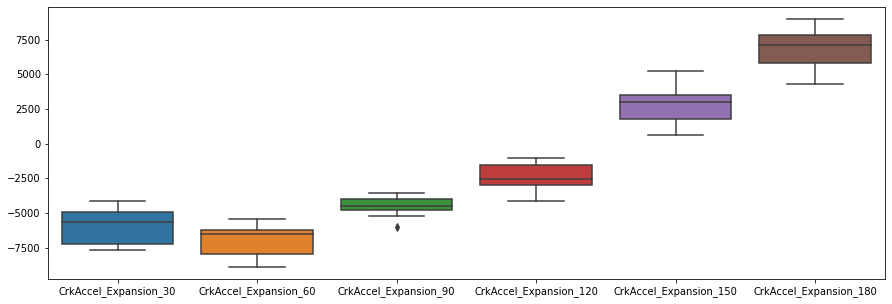

FF=0.33,HF=0.00,Curr:0,Prev:1,Next:0


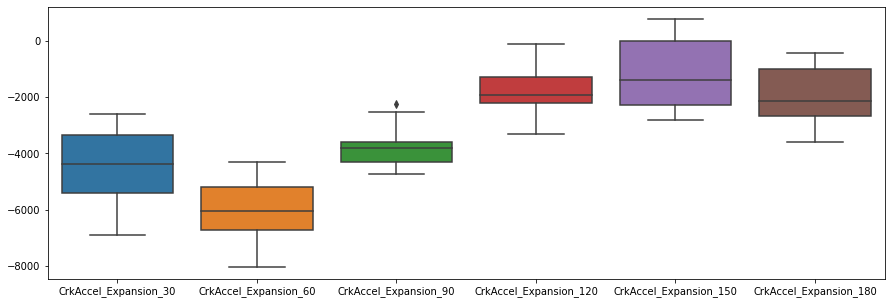

FF=0.33,HF=0.00,Curr:1,Prev:0,Next:0


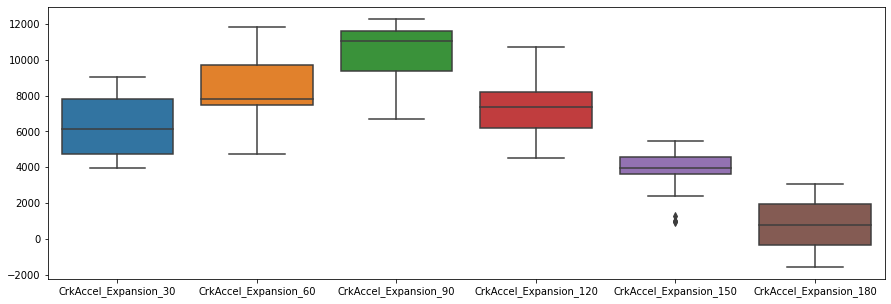

FF=0.33,HF=1.00,Curr:0,Prev:0,Next:2


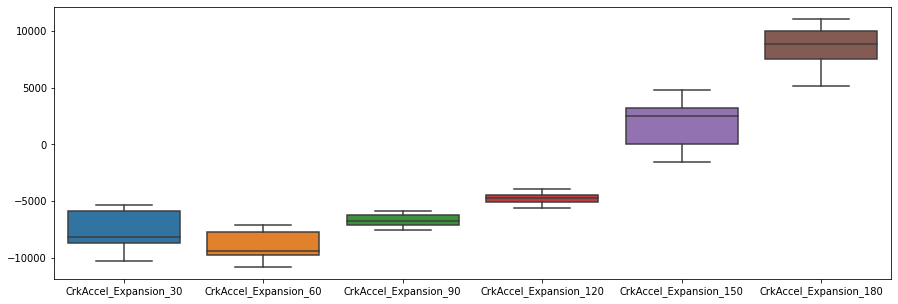

FF=0.33,HF=1.00,Curr:0,Prev:2,Next:0


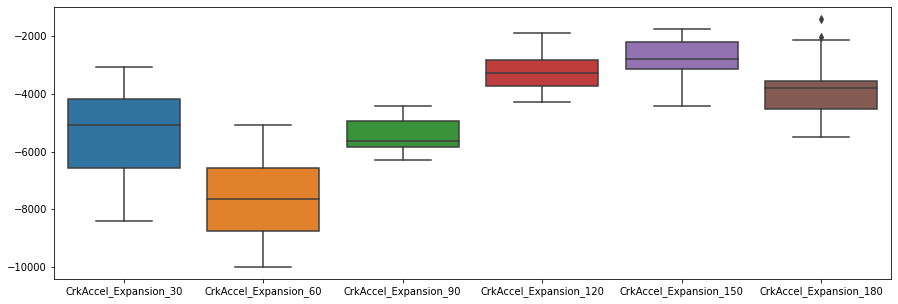

FF=0.33,HF=1.00,Curr:2,Prev:0,Next:0


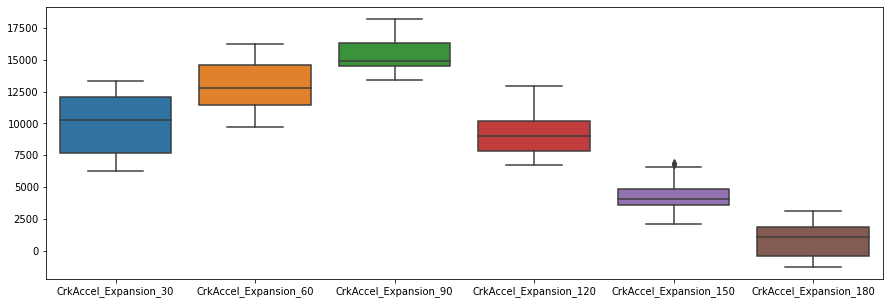

FF=0.40,HF=0.00,Curr:0,Prev:0,Next:1


FF=0.40,HF=0.00,Curr:0,Prev:1,Next:0


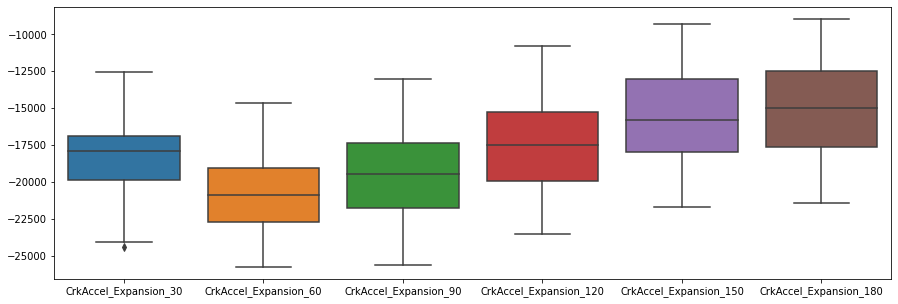

FF=0.40,HF=0.00,Curr:0,Prev:1,Next:1


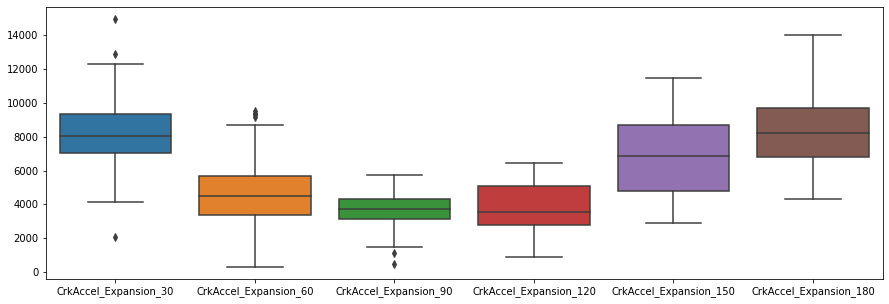

FF=0.40,HF=0.00,Curr:1,Prev:0,Next:0


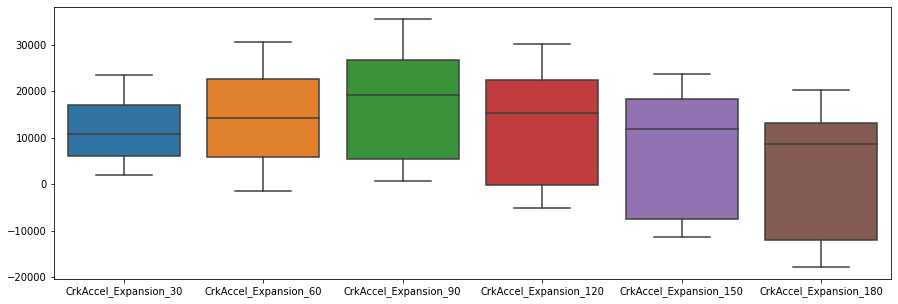

FF=0.40,HF=0.50,Curr:0,Prev:0,Next:2


FF=0.40,HF=0.50,Curr:0,Prev:1,Next:0


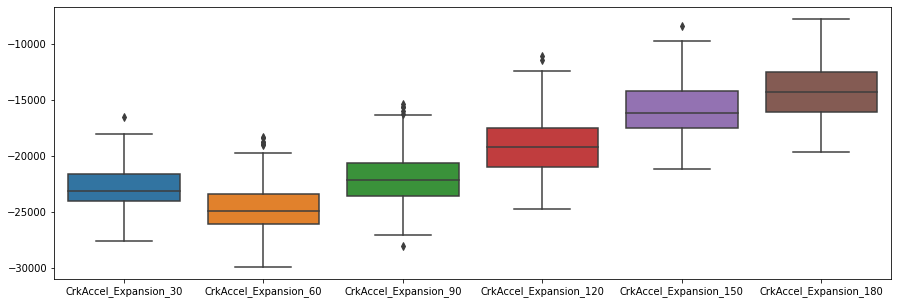

FF=0.40,HF=0.50,Curr:0,Prev:2,Next:1


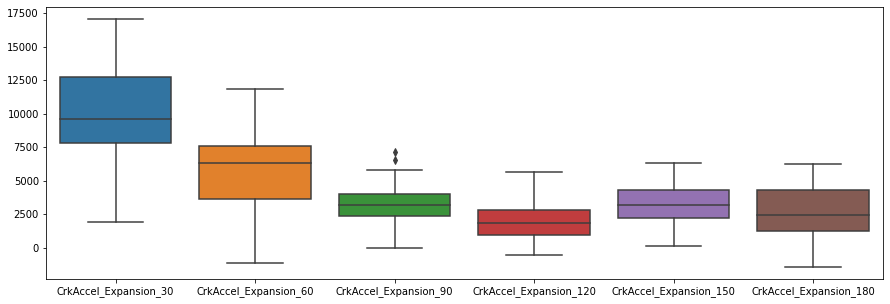

FF=0.40,HF=0.50,Curr:1,Prev:0,Next:0


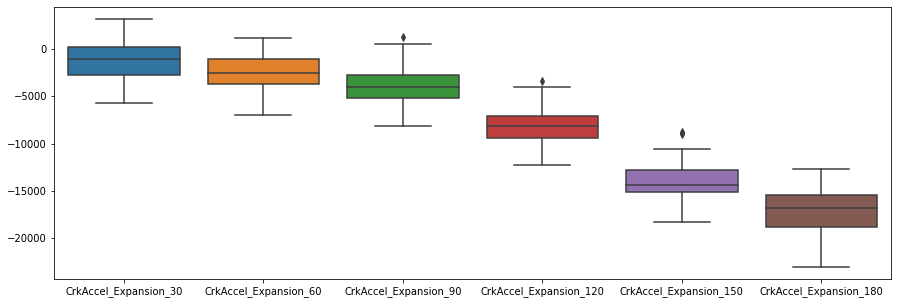

FF=0.40,HF=0.50,Curr:2,Prev:0,Next:0


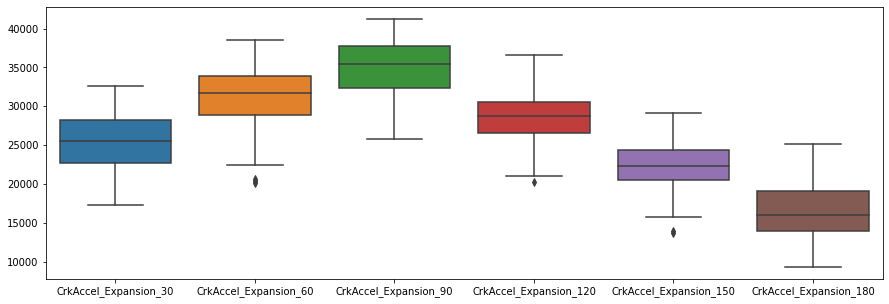

FF=0.40,HF=1.00,Curr:0,Prev:0,Next:2


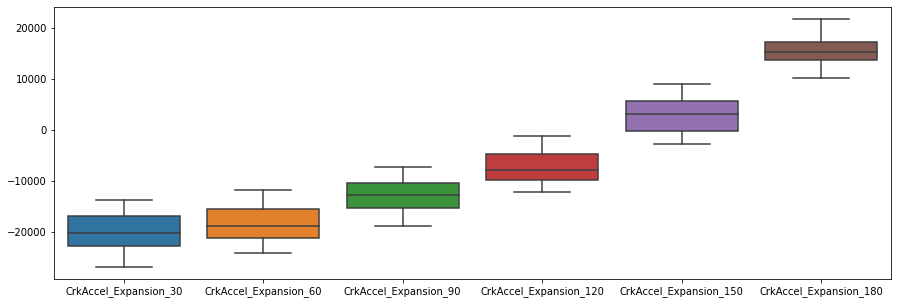

FF=0.40,HF=1.00,Curr:0,Prev:2,Next:0


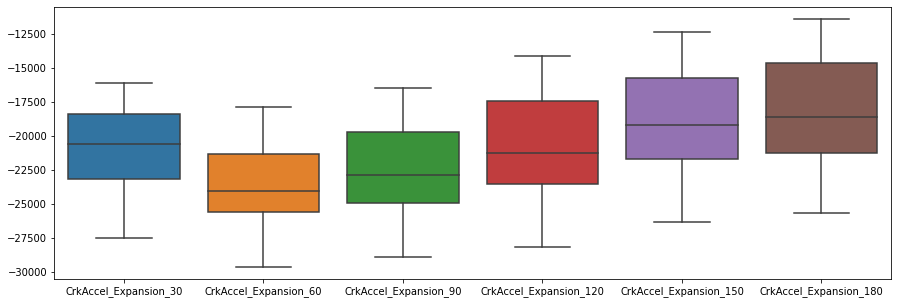

FF=0.40,HF=1.00,Curr:0,Prev:2,Next:2


FF=0.40,HF=1.00,Curr:2,Prev:0,Next:0


FF=0.67,HF=0.00,Curr:0,Prev:1,Next:1


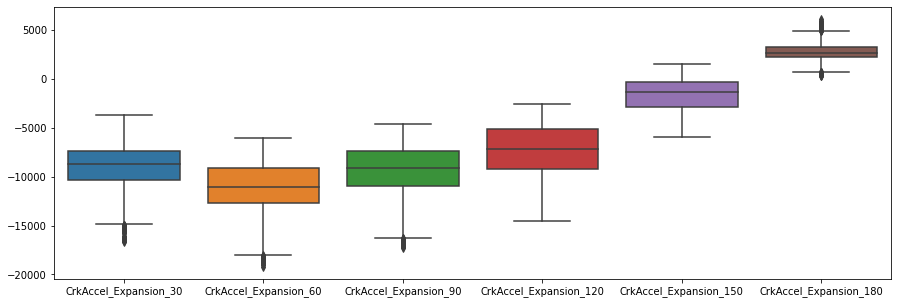

FF=0.67,HF=0.00,Curr:1,Prev:0,Next:1


FF=0.67,HF=0.00,Curr:1,Prev:1,Next:0


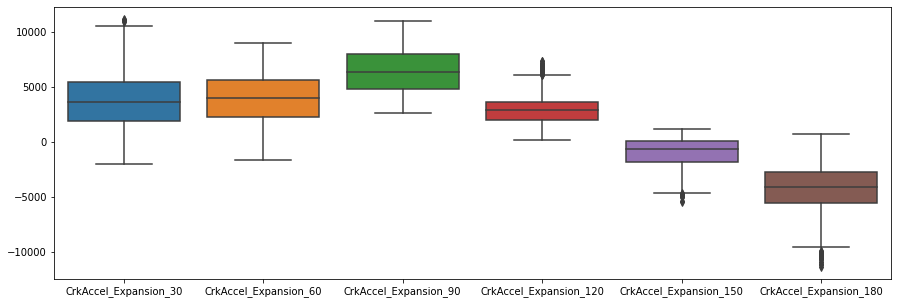

FF=0.67,HF=0.50,Curr:0,Prev:1,Next:2


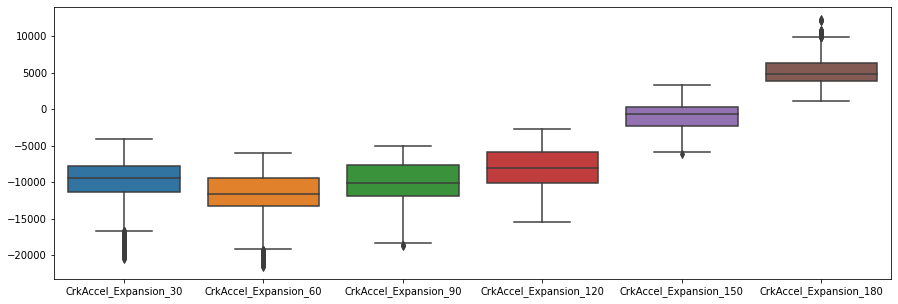

FF=0.67,HF=0.50,Curr:0,Prev:2,Next:1


FF=0.67,HF=0.50,Curr:1,Prev:0,Next:2


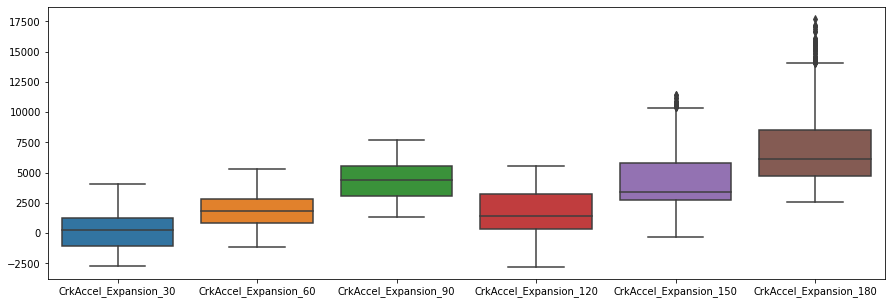

FF=0.67,HF=0.50,Curr:1,Prev:2,Next:0


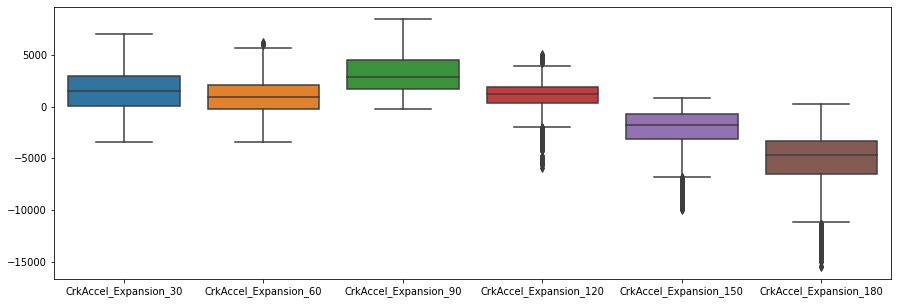

FF=0.67,HF=0.50,Curr:2,Prev:0,Next:1


FF=0.67,HF=0.50,Curr:2,Prev:1,Next:0


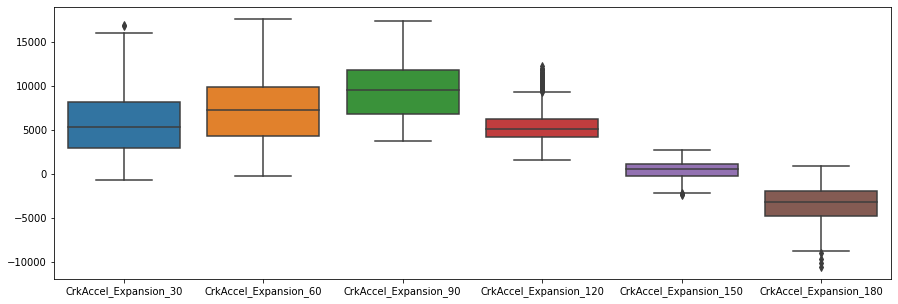

FF=0.67,HF=1.00,Curr:0,Prev:2,Next:2


FF=0.67,HF=1.00,Curr:2,Prev:0,Next:2


FF=0.67,HF=1.00,Curr:2,Prev:2,Next:0


FF=0.80,HF=0.00,Curr:0,Prev:1,Next:1


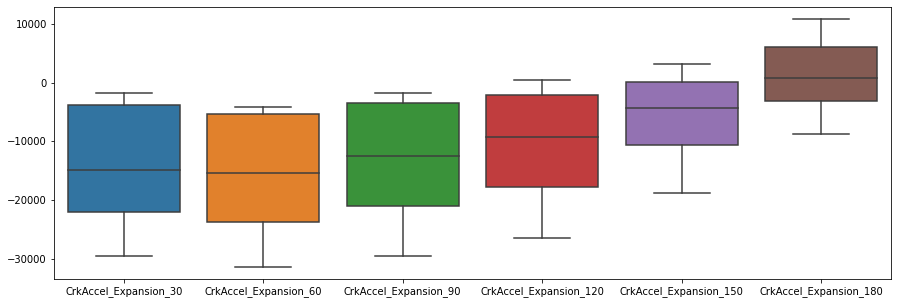

FF=0.80,HF=0.00,Curr:1,Prev:0,Next:1


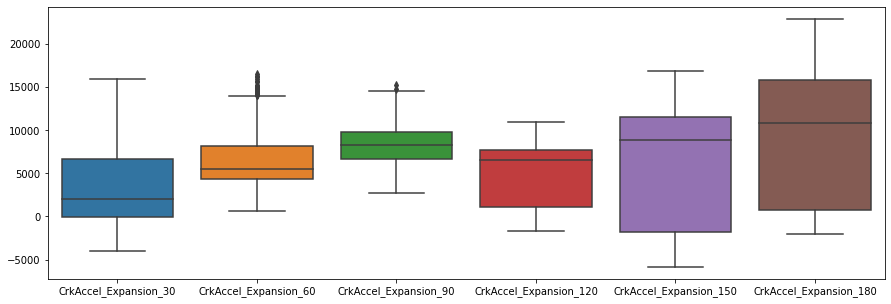

FF=0.80,HF=0.00,Curr:1,Prev:1,Next:0


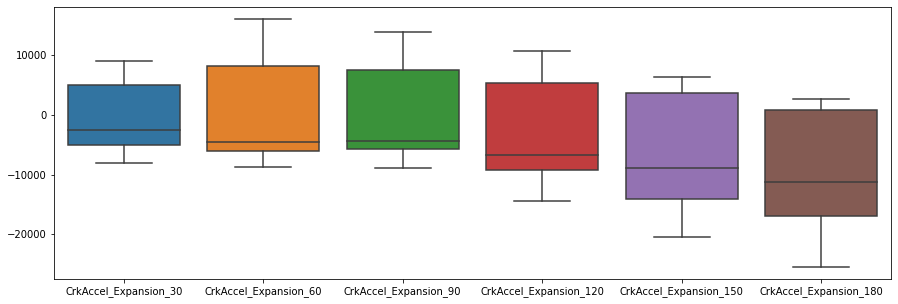

FF=0.80,HF=0.00,Curr:1,Prev:1,Next:1


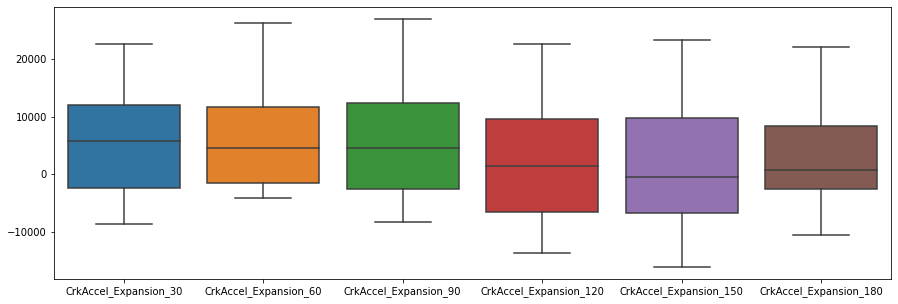

FF=0.80,HF=0.67,Curr:0,Prev:1,Next:2


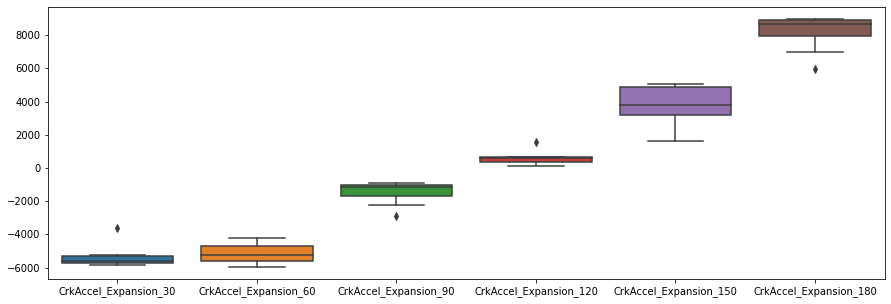

FF=0.80,HF=0.67,Curr:0,Prev:2,Next:1


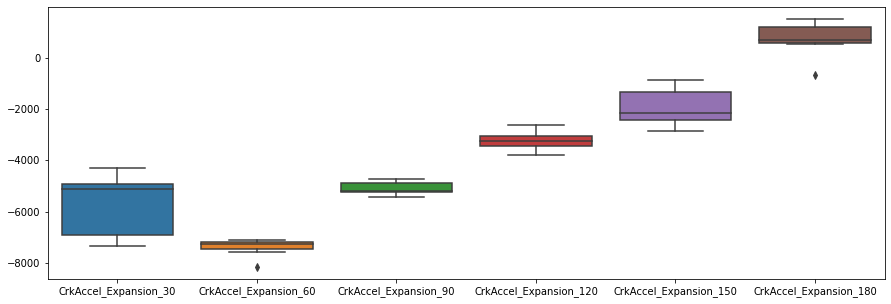

FF=0.80,HF=0.67,Curr:0,Prev:2,Next:2


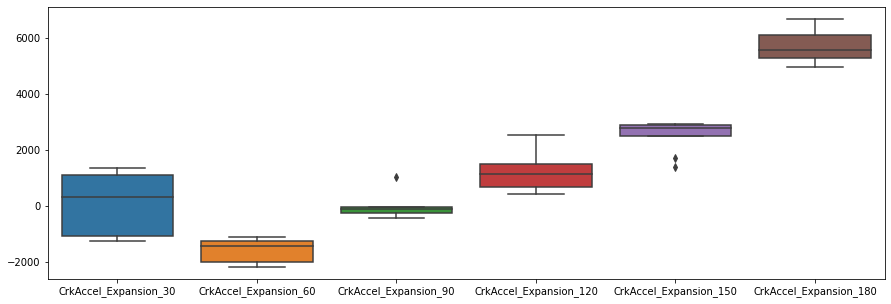

FF=0.80,HF=0.67,Curr:1,Prev:0,Next:2


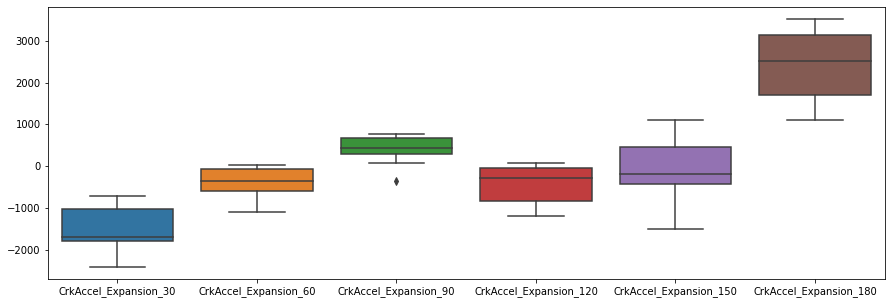

FF=0.80,HF=0.67,Curr:1,Prev:2,Next:0


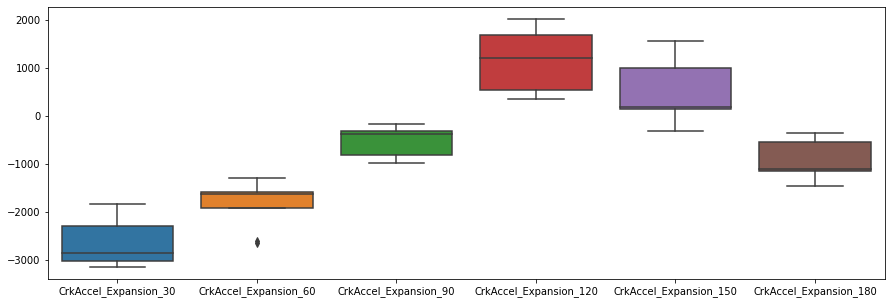

FF=0.80,HF=0.67,Curr:1,Prev:2,Next:2


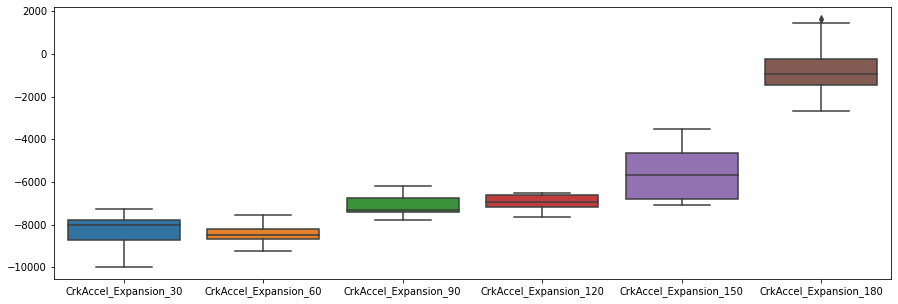

FF=0.80,HF=0.67,Curr:2,Prev:0,Next:1


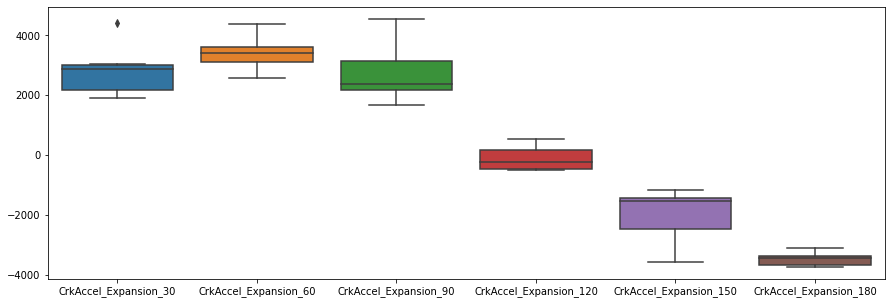

FF=0.80,HF=0.67,Curr:2,Prev:0,Next:2


FF=0.80,HF=0.67,Curr:2,Prev:1,Next:0


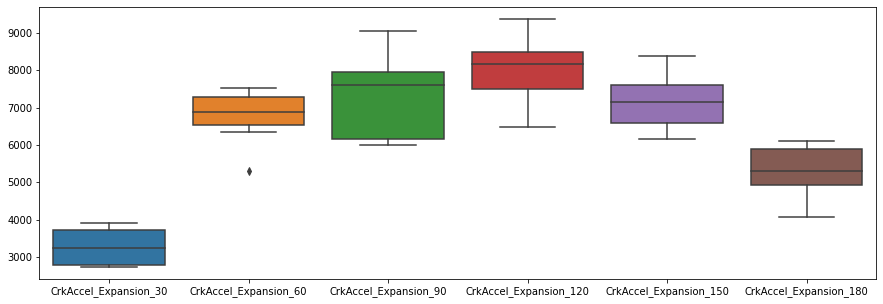

FF=0.80,HF=0.67,Curr:2,Prev:1,Next:2


FF=0.80,HF=0.67,Curr:2,Prev:2,Next:0


FF=0.80,HF=0.67,Curr:2,Prev:2,Next:1


FF=0.80,HF=0.75,Curr:0,Prev:2,Next:1


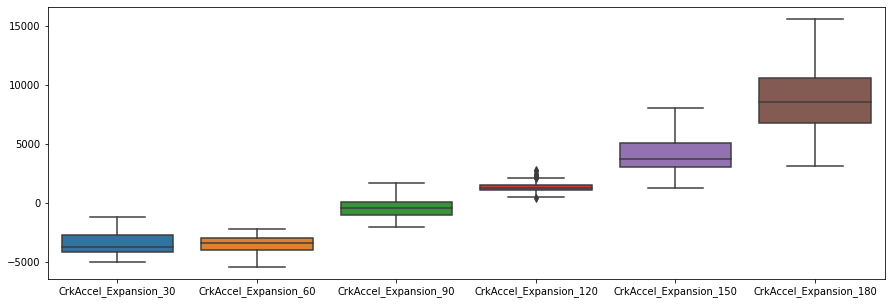

FF=0.80,HF=0.75,Curr:0,Prev:2,Next:2


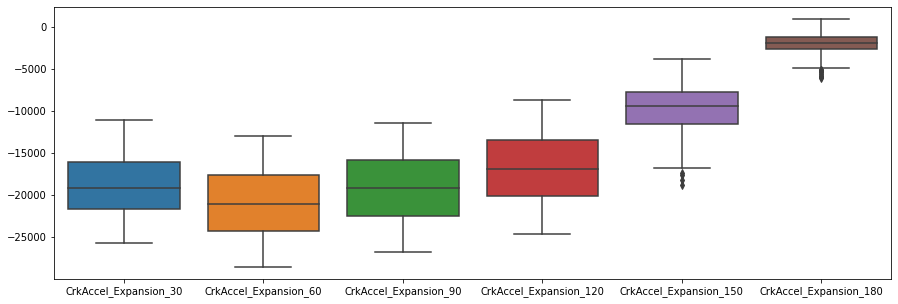

FF=0.80,HF=0.75,Curr:1,Prev:0,Next:2


FF=0.80,HF=0.75,Curr:1,Prev:2,Next:2


FF=0.80,HF=0.75,Curr:2,Prev:0,Next:1


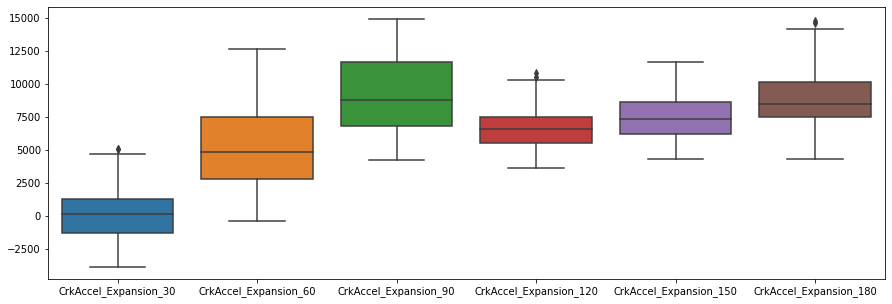

FF=0.80,HF=0.75,Curr:2,Prev:1,Next:2


FF=0.80,HF=0.75,Curr:2,Prev:2,Next:0


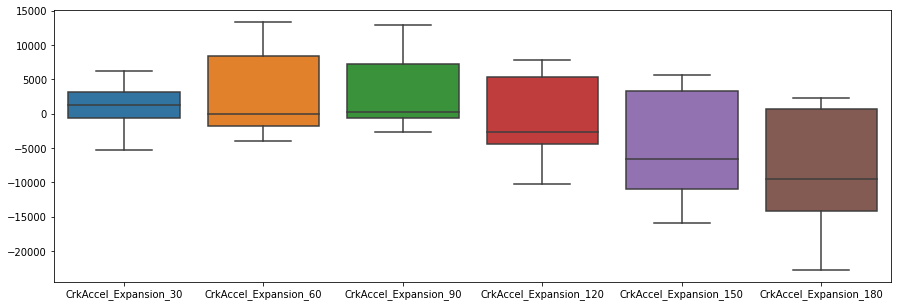

FF=0.80,HF=0.75,Curr:2,Prev:2,Next:2


FF=0.80,HF=1.00,Curr:0,Prev:2,Next:2


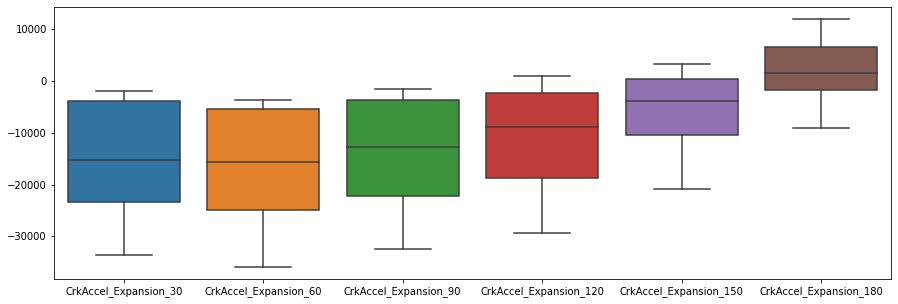

FF=0.80,HF=1.00,Curr:2,Prev:0,Next:2


FF=0.80,HF=1.00,Curr:2,Prev:2,Next:0


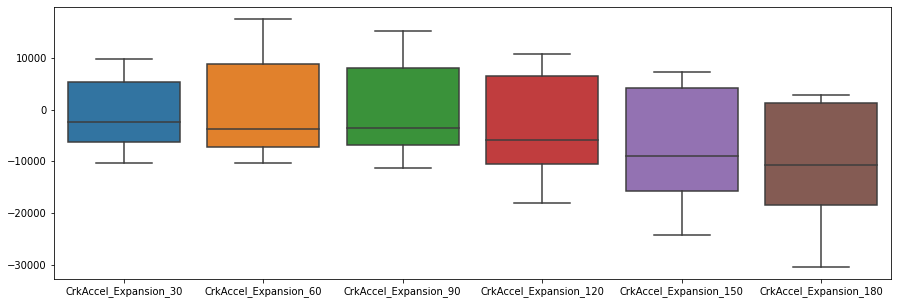

FF=0.80,HF=1.00,Curr:2,Prev:2,Next:2


FF=1.00,HF=0.00,Curr:1,Prev:1,Next:1


FF=1.00,HF=0.33,Curr:1,Prev:1,Next:2


FF=1.00,HF=0.33,Curr:1,Prev:2,Next:1


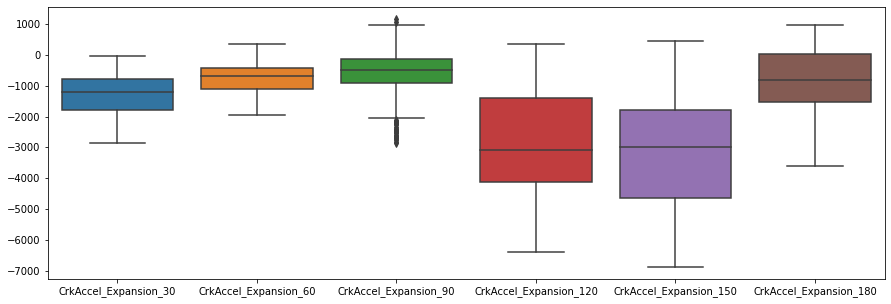

FF=1.00,HF=0.33,Curr:2,Prev:1,Next:1


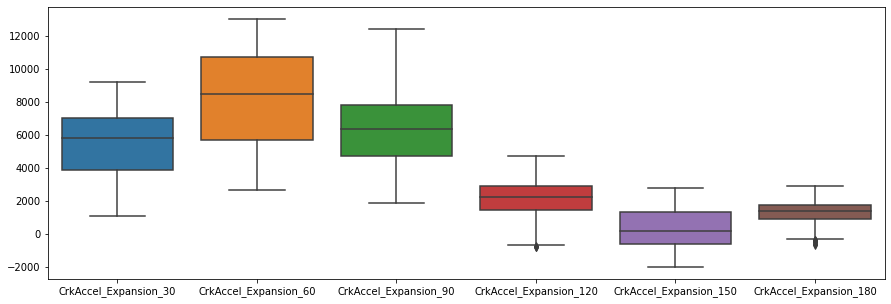

FF=1.00,HF=0.50,Curr:2,Prev:1,Next:1


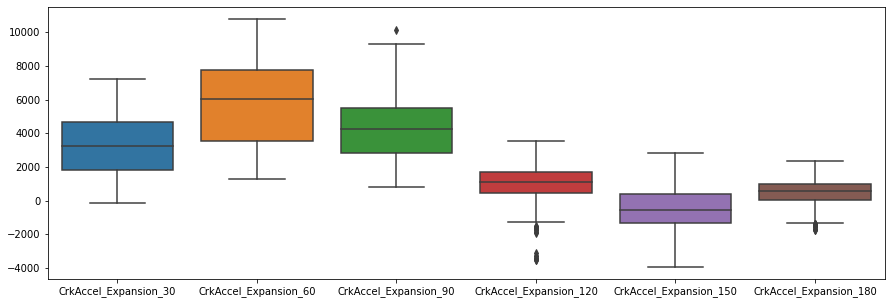

FF=1.00,HF=0.67,Curr:1,Prev:2,Next:2


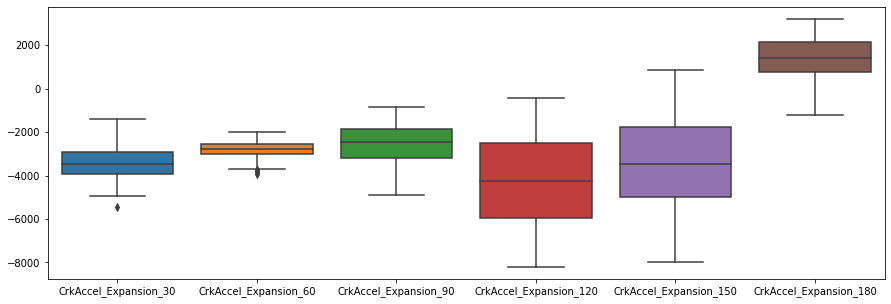

FF=1.00,HF=0.67,Curr:2,Prev:1,Next:2


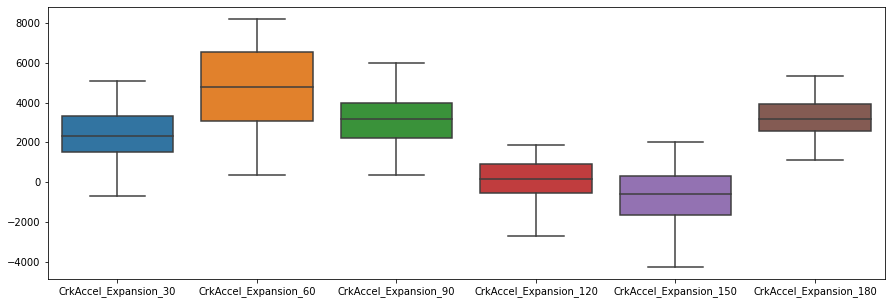

FF=1.00,HF=0.67,Curr:2,Prev:2,Next:1


FF=1.00,HF=1.00,Curr:2,Prev:2,Next:2


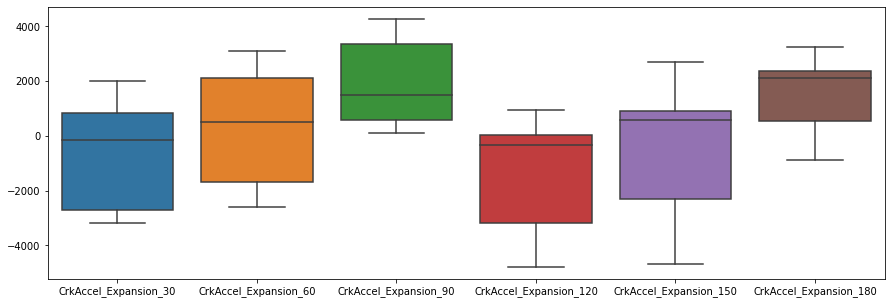

In [20]:
grouped_by = cyl_1_data_remove_FF_HF.groupby(FF_COLS+OUTPUT_COLS+CAT_COLS)

for group_name, df in grouped_by:
    print('FF={:0.2f},HF={:0.2f},Curr:{},Prev:{},Next:{}'.format(*group_name))
    plt.figure(figsize=(15,5))
    sns.boxplot(data=df[CAEXPANSION_COLS])
    plt.show()

In [ ]:
grouped_by = cyl_1_data_remove_FF_HF.groupby(FF_COLS+OUTPUT_COLS+CAT_COLS)

for group_name, df in grouped_by:
    print('FF={:0.2f},HF={:0.2f},Curr:{},Prev:{},Next:{}'.format(*group_name))
    plt.figure(figsize=(15,5))
    sns.boxplot(data=df[CACOMPRESS_COLS])
    plt.show()

In [ ]:
grouped_by = cyl_1_data_remove_FF_HF.groupby(FF_COLS+OUTPUT_COLS+CAT_COLS)
# rpm = [1500, 2000] +-100
for group_name, df in grouped_by:
    temp_data = df[(df['RPM']<=1600) & (df['RPM']>=1400)]
    if not temp_data.empty and np.isclose(0.8, group_name[0]) and np.isclose(0.75, group_name[1]):
        print('FF={:0.2f},HF={:0.2f},Curr:{},Prev:{},Next:{}, RPM = 1500+/-100'.format(*group_name))
        plt.figure(figsize=(15,5))
        sns.boxplot(data=temp_data[CAEXPANSION_COLS])
        plt.show()

In [ ]:
grouped_by = cyl_1_data_remove_FF_HF.groupby(FF_COLS+OUTPUT_COLS+CAT_COLS)
# rpm = [1500, 2000] +-100
for group_name, df in grouped_by:
    temp_data = df[(df['RPM']<=2100) & (df['RPM']>=1900)]
    if not temp_data.empty and np.isclose(0.8, group_name[0]) and np.isclose(0.75, group_name[1]):
        print('FF={:0.2f},HF={:0.2f},Curr:{},Prev:{},Next:{}, RPM = 2000+/-100'.format(*group_name))
        plt.figure(figsize=(15,5))
        sns.boxplot(data=temp_data[CAEXPANSION_COLS])
        plt.show()

Expansion being quite low as this cyl is not firing but the previous is expansion. The next cylinder is starting to expand before this completed. Maybe data not well aligned?

## MAF

In [ ]:
def two_plot(cols):
    print('Plots for ',cols)
    sns.distplot(cyl_1_data_remove_FF_HF[cols], fit=norm)
    plt.show()
    sns.boxplot(data=cyl_1_data_remove_FF_HF, x='CylStatus', y=cols)
    plt.show()

In [ ]:
sns.histplot(cyl_1_data, x='MAF',stat='density', kde=True, log_scale=True)

In [ ]:
print('Skewness: {:0.2f}'.format(cyl_1_data['MAF'].skew()))
print('Kurtosis: {:0.2f}'.format(cyl_1_data['MAF'].kurt()))

In [ ]:
for vars in COMMON_COLS:
    two_plot(vars)

## Correlations

In [21]:
corr_matrix = cyl_1_data_remove_FF_HF.drop(columns=['FF','HF']).corr()
corr_matrix['MAP_Intake_90'].sort_values(ascending=False)

MAP_Intake_90             1.000000
MAP_Intake_120            0.997040
MAP_Intake_60             0.994661
MAP_Intake_150            0.993594
MAP_Intake_180            0.991000
MAP_Intake_30             0.983790
NetTQ                     0.627896
MAF                       0.593903
IntCam                    0.366868
ExhCam                    0.317937
RPM                       0.142374
CrkAccel_Intake_60        0.076736
CrkAccel_Intake_90        0.070972
CrkAccel_Intake_30        0.057934
CrkAccel_Expansion_180    0.045528
CrkAccel_Compress_60      0.023698
CrkAccel_Compress_90      0.022786
CrkAccel_Compress_30      0.014961
CrkAccel_Intake_180       0.003384
CrkAccel_Intake_120      -0.007808
CrkAccel_Expansion_60    -0.025104
CrkAccel_Expansion_90    -0.028335
CrkAccel_Intake_150      -0.029532
CrkAccel_Expansion_30    -0.040702
CrkAccel_Expansion_150   -0.056613
CrkAccel_Compress_120    -0.058896
CrkAccel_Compress_180    -0.062596
CrkAccel_Compress_150    -0.085576
CrkAccel_Expansion_1

In [ ]:
sns.pairplot(cyl_1_data[['CylStatus', 'CrkAccel_Expansion_60', 'CylStatusNext']], height=4)

In [ ]:
sns.pairplot(cyl_1_data[['CylStatus', 'CrkAccel_Compress_30']], height=4)

In [ ]:
sns.pairplot(cyl_1_data_remove_FF_HF[CA], height=4)

## Prepare data

Remove the <-40000 point at index = 28513

In [10]:
# Remove one outlier
#cyl_1_data_remove_FF_HF.drop(28513, inplace=True)
data_X = pd.get_dummies(cyl_1_data_remove_FF_HF, 
                        columns=['CylStatusPrev','CylStatusNext'], drop_first=True)#, dtype='str')
X_train, y_train, X_test, y_test = train_test_split(data_X, 
                                                    col_2_split=OUTPUT_COLS, 
                                                    output_cols=OUTPUT_COLS, 
                                                    col_2_drop=FF_COLS+OUTPUT_COLS)

# just add constant to both train and test data
X_train.loc[:, 'const'] = 1
X_test.loc[:, 'const'] = 1
print('Train data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)

# standardize the data
cols_2_transform = COMMON_COLS+CACOMPRESS_COLS+CAEXPANSION_COLS+CAINTAKE_COLS+MAP_COLS
X_train_std, X_test_std = standardize_data(X_train, X_test, cols_transform=cols_2_transform)
print('Train std data shape: ', X_train_std.shape)
print('Test std data shape: ', X_test_std.shape)

Train data shape:  (28245, 34)
Test data shape:  (7062, 34)
Train std data shape:  (28245, 34)
Test std data shape:  (7062, 34)


## TODO: Isolation Trees

In [ ]:
len(data_X)*0.001

In [23]:
clf = IsolationForest(contamination=0.001, n_estimators=1000, n_jobs=-1, verbose=1)
ans = clf.fit_predict(data_X)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    4.1s remaining:   20.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    4.3s finished


In [24]:
ans=pd.Series(ans)
ans.value_counts()/(len(data_X))

 1    0.99898
-1    0.00102
dtype: float64

In [ ]:
pd.cut(clf.decision_function(data_X.iloc[ans[ans==-1].index]), 4).value_counts()

In [ ]:
pd.cut(clf.decision_function(data_X.iloc[ans[ans==1].index]), 5).value_counts()

In [25]:
anomoly_df = data_X.iloc[ans[ans==-1].index]
non_anomoly_df = data_X.iloc[ans[ans==1].index]
anomoly_df.describe()

CylStatus  MAP_Intake_30  MAP_Intake_60  MAP_Intake_90  MAP_Intake_120  \
count  36.000000      36.000000      36.000000      36.000000       36.000000   
mean    1.388889     114.198727     112.181119     108.790799      107.196980   
std     0.837608       7.003140       6.565024       7.140251        8.377763   
min     0.000000     101.604795      98.951502      95.634885       93.644915   
25%     1.000000     111.886308     113.461701     107.243044      105.253074   
50%     2.000000     115.534587     114.373771     108.901353      105.584736   
75%     2.000000     119.929105     114.871264     114.456686      113.627532   
max     2.000000     122.167821     119.182866     116.861234      117.856219   

       MAP_Intake_150  MAP_Intake_180        MAF       NetTQ     IntCam  ...  \
count       36.000000       36.000000  36.000000   36.000000  36.000000  ...   
mean       107.934006      111.195346  15.816081   84.097387  46.231917  ...   
std          8.569965        7.245282   3.370568   20.257689   4.945376  ...   
min         94.308238      100.278149  12.717540   68.362584  35.443605  ...   
25%        104.921412      108.155114  13.165307   68.595948  47.623162  ...   
50%        105.253074      108.901353  13.632111   70.138257  47.848229  ...   
75%        117.027065      118.187881  19.938796  109.139780  48.046793  ...   
max        118.519542      121.504498  20.750634  112.473895  50.364262  ...   

       CrkAccel_Expansion_30  CrkAccel_Expansion_60  CrkAccel_Expansion_90  \
count              36.000000              36.000000              36.000000   
mean            22410.983531           25595.322197           27299.836390   
std              5484.155979           10460.567854           13045.373803   
min              9266.765585            5292.541201            4258.434025   
25%             19739.770313           21652.270321           25237.078546   
50%             23383.272088           25277.529698           27870.686105   
75%             26957.957317           34802.228083           38301.695263   
max             30539.487170           38753.980082           43082.816650   

       CrkAccel_Expansion_120  CrkAccel_Expansion_150  CrkAccel_Expansion_180  \
count               36.000000               36.000000               36.000000   
mean             22163.068272            20254.424993            17246.866853   
std              10741.950965             6154.336807             3555.590898   
min               3614.880322             7551.245249             9448.225716   
25%              18501.540262            16990.541437            15769.822605   
50%              23111.048334            21086.345339            17981.487914   
75%              30814.606030            25449.405455            18907.389997   
max              36550.497774            28139.021521            24383.741104   

       CylStatusPrev_1  CylStatusPrev_2  CylStatusNext_1  CylStatusNext_2  
count        36.000000        36.000000        36.000000        36.000000  
mean          0.166667         0.416667         0.166667         0.416667  
std           0.377964         0.500000         0.377964         0.500000  
min           0.000000         0.000000         0.000000         0.000000  
25%           0.000000         0.000000         0.000000         0.000000  
50%           0.000000         0.000000         0.000000         0.000000  
75%           0.000000         1.000000         0.000000         1.000000  
max           1.000000         1.000000         1.000000         1.000000  

[8 rows x 36 columns]

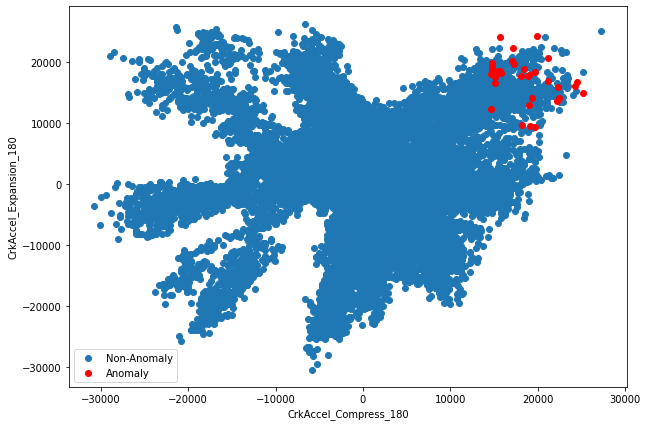

In [26]:
y='CrkAccel_Expansion_180'
x='CrkAccel_Compress_180'
plt.figure(figsize=(10,7))
plt.scatter(data=non_anomoly_df,x=x, y=y, label = 'Non-Anomaly')
plt.scatter(data=anomoly_df,x=x, y=y,c='r', label='Anomaly')
plt.xlabel(x)
plt.ylabel(y)
plt.legend()
plt.show()

# VIF

In [ ]:
data_X_std = standard_scaler(data=data_X, columns_transform=cols_2_transform)
data_X_std.loc[:, 'const'] = 1
print(calc_vif(data=data_X_std, cols=COMMON_COLS+['const']).sort_values(by='VIF'))
print('-'*50)
print(calc_vif(data=data_X_std).sort_values(by='VIF'))

In [ ]:
temp_X = data_X_std.copy()
vif_df = calc_vif(data=temp_X)
while vif_df.VIF.max() > 7:
    col = vif_df.iloc[vif_df.VIF.idxmax()].features
    if col == 'const':
        idx = vif_df.drop(vif_df.VIF.idxmax()).VIF.idxmax() # what is the other column other than const
        col = vif_df.iloc[idx].features
        if vif_df.iloc[idx].VIF < 10: break
    temp_X.drop(columns=col, inplace=True)
    vif_df = calc_vif(data=temp_X)
#     vif_df = pd.DataFrame()
#     vif_df['VIF'] = [variance_inflation_factor(temp_X.values,i) for i in range(temp_X.shape[1])]
#     vif_df['features'] = temp_X.columns

In [ ]:
vif_df.sort_values(by='VIF')

In [ ]:
corr_matrix = temp_X.corr()
#sns.heatmap(corr_matrix)
corr_matrix['MAF'].sort_values(ascending=False)

VIF on the train data and use the columns from that

In [27]:
temp_X = X_train_std.copy()
vif_df = calc_vif(data=temp_X)
while vif_df.VIF.max() > 4:
    col = vif_df.iloc[vif_df.VIF.idxmax()].features
    if col == 'const':
        idx = vif_df.drop(vif_df.VIF.idxmax()).VIF.idxmax() # what is the other column other than const
        col = vif_df.iloc[idx].features
        if vif_df.iloc[idx].VIF < 4: break
    temp_X.drop(columns=col, inplace=True)
    vif_df = calc_vif(data=temp_X)
vif_df.sort_values(by='VIF')

VIF                features
3   1.257045                     RPM
6   1.418648  CrkAccel_Expansion_180
11  1.491284         CylStatusNext_1
9   1.497623         CylStatusPrev_1
1   1.502425                  IntCam
5   1.804116   CrkAccel_Expansion_60
7   1.891041      CrkAccel_Intake_30
4   1.896742   CrkAccel_Compress_150
8   2.293813           MAP_Intake_30
0   2.310054                     MAF
2   2.342326                  ExhCam
10  3.542271                   const

# PCA

In [ ]:
# do PCA & find the reduced dim variable list?

# Logistic Regression

Use statmodels(multiclass) and understand the coeffcients, using VIF selected features

In [ ]:
corr_mat = data_X[list(vif_df.features[:-1])+['CylStatus']].corr()
corr_mat['CylStatus'].sort_values(ascending=False)

In [12]:
result.mle_retvals

{'fopt': 4.648247411843398e-05,
 'fcalls': 35,
 'gcalls': 35,
 'hcalls': 35,
 'warnflag': 0,
 'converged': True}

In [11]:
logit_model=sm.MNLogit(y_train,X_train_std)
logit_model
result=logit_model.fit(method='ncg', maxiter=3000)
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 35
         Function evaluations: 35
         Gradient evaluations: 35
         Hessian evaluations: 35
                          MNLogit Regression Results                          
Dep. Variable:              CylStatus   No. Observations:                28245
Model:                        MNLogit   Df Residuals:                    28177
Method:                           MLE   Df Model:                           66
Date:                Mon, 05 Apr 2021   Pseudo R-squ.:                   1.000
Time:                        15:33:38   Log-Likelihood:                -1.3129
converged:                       True   LL-Null:                       -30569.
Covariance Type:            nonrobust   LLR p-value:                     0.000
           CylStatus=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

**Train Results**

For training data:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      7293
           1       1.00      1.00      1.00     11425
           2       1.00      1.00      1.00      9527

    accuracy                           1.00     28245
   macro avg       1.00      1.00      1.00     28245
weighted avg       1.00      1.00      1.00     28245



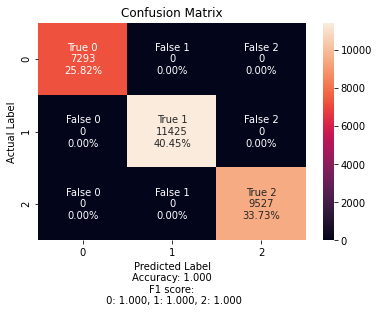

In [13]:
y_preds_tr = result.predict(X_train_std)
y_preds_tr = y_preds_tr.idxmax(axis=1).values
cf_matrix = confusion_matrix(y_train, y_preds_tr)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')
print('For training data: ', classification_report(y_train, y_preds_tr))

**Test Results**

In [14]:
y_preds = result.predict(X_test_std)
y_preds = y_preds.idxmax(axis=1).values
cf_matrix = confusion_matrix(y_test, y_preds)
plot_stats(cf_matrix, y_test, y_preds, title='Confusion Matrix')
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1823
           1       1.00      1.00      1.00      2857
           2       1.00      1.00      1.00      2382

    accuracy                           1.00      7062
   macro avg       1.00      1.00      1.00      7062
weighted avg       1.00      1.00      1.00      7062



**Points where actual and predicted**

In [31]:
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        d = cyl_1_data_remove_FF_HF.loc[find_data_mismatch(y_test, y_preds, 
                                                           pred_label=preds, 
                                                           actual_label=actual)][FF_COLS+OUTPUT_COLS+CAT_COLS+COMMON_COLS]
        if not d.empty:
            print('-'*100)
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)

----------------------------------------------------------------------------------------------------
Predicted: 0 but actual: 1


FF      HF  CylStatus  CylStatusPrev  CylStatusNext       MAF  \
23416  0.8  0.6667          1              2              2  6.047587   

           NetTQ     IntCam    ExhCam          RPM  
23416  32.554933  38.473721  8.280695  1553.536956

----------------------------------------------------------------------------------------------------
Predicted: 1 but actual: 2


FF   HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
14114  0.6667  0.5          2              0              1  17.923079   

            NetTQ     IntCam    ExhCam          RPM  
14114  100.051966  43.071614  12.22963  2026.234751

**VIF based Logistic Regression**

In [32]:
logit_model=sm.MNLogit(y_train,X_train_std[vif_df.features.values])
logit_model
result=logit_model.fit(method='ncg', maxiter=3000)
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: 0.123857
         Iterations: 60
         Function evaluations: 62
         Gradient evaluations: 62
         Hessian evaluations: 60
                          MNLogit Regression Results                          
Dep. Variable:              CylStatus   No. Observations:                28245
Model:                        MNLogit   Df Residuals:                    28221
Method:                           MLE   Df Model:                           22
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                  0.8856
Time:                        12:02:57   Log-Likelihood:                -3498.3
converged:                       True   LL-Null:                       -30569.
Covariance Type:            nonrobust   LLR p-value:                     0.000
           CylStatus=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

**Train Results**

For training data:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      7293
           1       0.94      0.94      0.94     11425
           2       0.93      0.93      0.93      9527

    accuracy                           0.95     28245
   macro avg       0.96      0.96      0.96     28245
weighted avg       0.95      0.95      0.95     28245



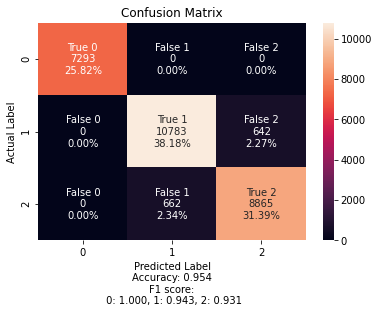

In [33]:
y_preds_tr = result.predict(X_train_std[vif_df.features.values])
y_preds_tr = y_preds_tr.idxmax(axis=1).values
cf_matrix = confusion_matrix(y_train, y_preds_tr)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')
print('For training data: ', classification_report(y_train, y_preds_tr))

**Test Results**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1823
           1       0.94      0.94      0.94      2857
           2       0.93      0.93      0.93      2382

    accuracy                           0.95      7062
   macro avg       0.96      0.96      0.96      7062
weighted avg       0.95      0.95      0.95      7062



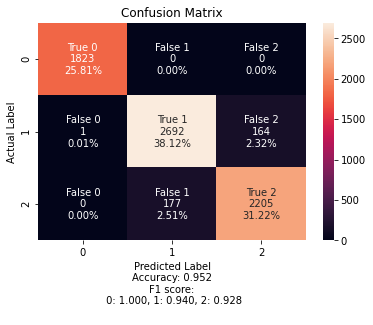

In [34]:
y_preds = result.predict(X_test_std[vif_df.features.values])
y_preds = y_preds.idxmax(axis=1).values
cf_matrix = confusion_matrix(y_test, y_preds)
plot_stats(cf_matrix, y_test, y_preds, title='Confusion Matrix')
print(classification_report(y_test, y_preds))

In [35]:
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        d = cyl_1_data_remove_FF_HF.loc[find_data_mismatch(y_test, y_preds, 
                                                           pred_label=preds, 
                                                           actual_label=actual)][FF_COLS+OUTPUT_COLS+CAT_COLS+COMMON_COLS]
        if not d.empty:
            print('-'*100)
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)

----------------------------------------------------------------------------------------------------
Predicted: 0 but actual: 1


FF      HF  CylStatus  CylStatusPrev  CylStatusNext       MAF  \
23416  0.8  0.6667          1              2              2  6.047587   

           NetTQ     IntCam    ExhCam          RPM  
23416  32.554933  38.473721  8.280695  1553.536956

----------------------------------------------------------------------------------------------------
Predicted: 1 but actual: 2


FF    HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
38524  0.6667  0.50          2              1              0   7.100113   
23723  0.8000  1.00          2              2              2   8.749314   
25210  0.8000  1.00          2              2              2   7.883636   
41297  0.6667  0.50          2              0              1  16.423202   
38011  0.6667  0.50          2              0              1  14.093169   
...       ...   ...        ...            ...            ...        ...   
40930  0.6667  0.50          2              0              1  14.205432   
38428  0.6667  0.50          2              1              0   7.131590   
23554  0.8000  0.75          2              2              2   7.579936   
15783  0.4000  0.50          2              0              0   8.811143   
38557  0.6667  0.50          2              1              0   8.356692   

           NetTQ     IntCam     ExhCam          RPM  
38524  31.360852   9.992641   9.508466  1986.222499  
23723  55.054152  45.655338  10.144118  1516.728408  
25210  41.663569  47.492372   8.959895  1543.010908  
41297  92.554046  10.119443  12.635102  2022.083576  
38011  76.637501  50.554213  11.623267  2023.304743  
...          ...        ...        ...          ...  
40930  77.264529  10.114801  11.959121  2018.216284  
38428  31.454535   9.979029   9.569674  1991.243126  
23554  42.309916  45.745397   8.749836  1555.754158  
15783  46.467774  50.338292  11.659052  1813.590218  
38557  38.864477  10.004571  10.375089  1984.819874  

[177 rows x 10 columns]

----------------------------------------------------------------------------------------------------
Predicted: 2 but actual: 1


FF    HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
44663  1.0000  0.00          1              1              1   7.677530   
44641  1.0000  0.00          1              1              1   7.746620   
24354  0.8000  0.75          1              0              2  12.951669   
44653  1.0000  0.00          1              1              1   7.762483   
27399  0.8000  0.00          1              1              0  15.516588   
...       ...   ...        ...            ...            ...        ...   
24445  0.8000  0.75          1              0              2  13.810098   
44802  1.0000  0.00          1              1              1   8.728259   
16040  0.8000  0.75          1              2              2   8.104090   
24788  0.8000  0.75          1              0              2  15.668555   
12831  0.6667  0.50          1              2              0   9.077819   

            NetTQ     IntCam     ExhCam          RPM  
44663   30.955530  36.653211   8.516304  2002.960630  
44641   30.996784  36.647118   8.448577  1999.494881  
24354   94.885610  46.348604  13.515466  1468.734709  
44653   30.960181  36.740592   8.400581  2000.813968  
27399   98.936509  40.228099  10.849668  1467.951039  
...           ...        ...        ...          ...  
24445  102.195650  46.728947  13.464625  1457.821814  
44802   38.915982  40.760360   9.468632  2003.789648  
16040   33.498396  45.036961  10.539913  1922.735082  
24788  120.722384  43.307989  12.074473  1440.701599  
12831   38.611026  45.911415  11.633324  1975.640608  

[164 rows x 10 columns]

In [ ]:
cyl_1_data_remove_FF_HF.loc[[28513]][COMMON_COLS+CAT_COLS+OUTPUT_COLS+FF_COLS]

### sklearn 

In [15]:
log_reg = LogisticRegression(random_state=0, 
                             multi_class='multinomial', 
                             penalty='none', 
                             solver='newton-cg',
                             fit_intercept=False,
                             n_jobs=-1)
log_reg.fit(X_train_std, y_train.values.ravel())

LogisticRegression(fit_intercept=False, multi_class='multinomial', n_jobs=-1,
                   penalty='none', random_state=0, solver='newton-cg')

**Train Results**

For training data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7293
           1       1.00      1.00      1.00     11425
           2       1.00      1.00      1.00      9527

    accuracy                           1.00     28245
   macro avg       1.00      1.00      1.00     28245
weighted avg       1.00      1.00      1.00     28245



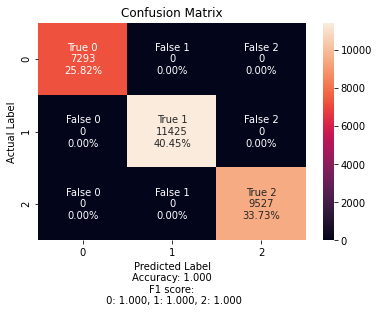

In [16]:
y_preds_tr = log_reg.predict(X_train_std)
cf_matrix = confusion_matrix(y_train, y_preds_tr)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')

print('For training data: \n', classification_report(y_train, y_preds_tr))

**Test Results**

For testing data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1823
           1       1.00      1.00      1.00      2857
           2       1.00      1.00      1.00      2382

    accuracy                           1.00      7062
   macro avg       1.00      1.00      1.00      7062
weighted avg       1.00      1.00      1.00      7062



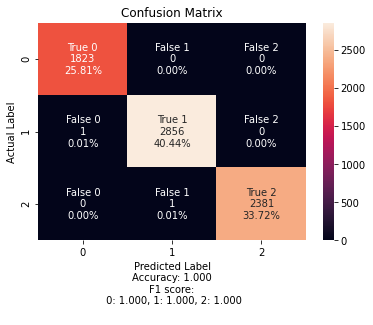

In [17]:
y_preds = log_reg.predict(X_test_std)
cf_matrix = confusion_matrix(y_test, y_preds)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')

print('For testing data: \n', classification_report(y_test, y_preds))

In [20]:
X_train_std.columns

Index(['MAF', 'NetTQ', 'IntCam', 'ExhCam', 'RPM', 'CrkAccel_Compress_30',
       'CrkAccel_Compress_60', 'CrkAccel_Compress_90', 'CrkAccel_Compress_120',
       'CrkAccel_Compress_150', 'CrkAccel_Compress_180',
       'CrkAccel_Expansion_30', 'CrkAccel_Expansion_60',
       'CrkAccel_Expansion_90', 'CrkAccel_Expansion_120',
       'CrkAccel_Expansion_150', 'CrkAccel_Expansion_180',
       'CrkAccel_Intake_30', 'CrkAccel_Intake_60', 'CrkAccel_Intake_90',
       'CrkAccel_Intake_120', 'CrkAccel_Intake_150', 'CrkAccel_Intake_180',
       'MAP_Intake_30', 'MAP_Intake_60', 'MAP_Intake_90', 'MAP_Intake_120',
       'MAP_Intake_150', 'MAP_Intake_180', 'CylStatusNext_1',
       'CylStatusPrev_2', 'CylStatusPrev_1', 'CylStatusNext_2', 'const'],
      dtype='object')

**Points where actual & predicted differ**

In [39]:
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        d = cyl_1_data_remove_FF_HF.loc[find_data_mismatch(y_test, y_preds, 
                                                           pred_label=preds, 
                                                           actual_label=actual)][FF_COLS+OUTPUT_COLS+CAT_COLS+COMMON_COLS]
        if not d.empty:
            print('-'*100)
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)

----------------------------------------------------------------------------------------------------
Predicted: 0 but actual: 1


FF      HF  CylStatus  CylStatusPrev  CylStatusNext       MAF  \
23416  0.8  0.6667          1              2              2  6.047587   

           NetTQ     IntCam    ExhCam          RPM  
23416  32.554933  38.473721  8.280695  1553.536956

----------------------------------------------------------------------------------------------------
Predicted: 1 but actual: 2


FF   HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
14114  0.6667  0.5          2              0              1  17.923079   

            NetTQ     IntCam    ExhCam          RPM  
14114  100.051966  43.071614  12.22963  2026.234751

### Crank up some penalty - L2 Regularization

In [8]:
log_reg = LogisticRegression(random_state=0, 
                             multi_class='multinomial', 
                             #penalty='none', 
                             solver='newton-cg',
                             fit_intercept=False,
                             n_jobs=-1)
log_reg.fit(X_train_std, y_train.values.ravel())

LogisticRegression(fit_intercept=False, multi_class='multinomial', n_jobs=-1,
                   random_state=0, solver='newton-cg')

**Train Results**

For training data with L2 regularization: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12892
           1       1.00      1.00      1.00     13186
           2       1.00      1.00      1.00     14945

    accuracy                           1.00     41023
   macro avg       1.00      1.00      1.00     41023
weighted avg       1.00      1.00      1.00     41023



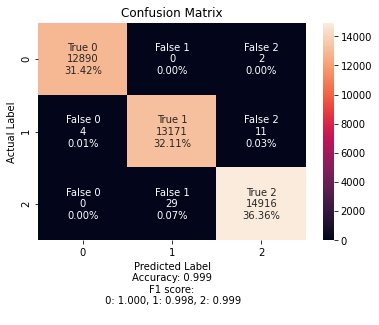

In [9]:
y_preds_tr = log_reg.predict(X_train_std)
cf_matrix = confusion_matrix(y_train, y_preds_tr)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')
print('For training data with L2 regularization: \n', classification_report(y_train, y_preds_tr))

**Test Results**

In [42]:
y_preds = log_reg.predict(X_test_std)
cf_matrix = confusion_matrix(y_test, y_preds)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')

print('For testing data with L2 regularization: \n', classification_report(y_test, y_preds))

For testing data with L2 regularization: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1823
           1       1.00      1.00      1.00      2857
           2       1.00      1.00      1.00      2382

    accuracy                           1.00      7062
   macro avg       1.00      1.00      1.00      7062
weighted avg       1.00      1.00      1.00      7062



In [43]:
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        d = cyl_1_data_remove_FF_HF.loc[find_data_mismatch(y_test, y_preds, 
                                                           pred_label=preds, 
                                                           actual_label=actual)][FF_COLS+OUTPUT_COLS+CAT_COLS+COMMON_COLS]
        if not d.empty: 
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)
            print('-'*100)

Predicted: 0 but actual: 1


FF      HF  CylStatus  CylStatusPrev  CylStatusNext       MAF  \
23416  0.8  0.6667          1              2              2  6.047587   

           NetTQ     IntCam    ExhCam          RPM  
23416  32.554933  38.473721  8.280695  1553.536956

----------------------------------------------------------------------------------------------------
Predicted: 1 but actual: 2


FF    HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
38440  0.6667  0.50          2              1              0   7.270881   
38533  0.6667  0.50          2              1              0   7.198018   
14114  0.6667  0.50          2              0              1  17.923079   
24699  0.8000  0.75          2              2              2  14.666518   
39948  0.6667  0.50          2              0              1   7.220697   
38521  0.6667  0.50          2              1              0   7.314682   
38470  0.6667  0.50          2              1              0   7.143905   
38539  0.6667  0.50          2              1              0   7.097895   
38452  0.6667  0.50          2              1              0   7.068658   
38428  0.6667  0.50          2              1              0   7.131590   

            NetTQ     IntCam     ExhCam          RPM  
38440   31.471042   9.957265   9.582058  1985.740539  
38533   31.546391   9.952337   9.546637  1989.313544  
14114  100.051966  43.071614  12.229630  2026.234751  
24699  105.003387  45.127465  11.933603  1625.635230  
39948   32.608042  10.242085   9.283254  2014.364458  
38521   31.422330   9.956624   9.717609  1985.541240  
38470   31.416934  10.012511   9.587922  1987.513114  
38539   31.485387   9.938161   9.525278  1987.172076  
38452   31.539347   9.995225   9.590063  1984.791638  
38428   31.454535   9.979029   9.569674  1991.243126

----------------------------------------------------------------------------------------------------


### L1 regularization

In [23]:
log_reg = LogisticRegression(random_state=0, 
                             multi_class='multinomial', 
                             penalty='l1', 
                             solver='saga',
                             max_iter=10000,
                             fit_intercept=False,
                             n_jobs=-1)
log_reg.fit(X_train_std, y_train.values.ravel())

LogisticRegression(fit_intercept=False, max_iter=10000,
                   multi_class='multinomial', n_jobs=-1, penalty='l1',
                   random_state=0, solver='saga')

**Train Results**

In [24]:
y_preds_tr = log_reg.predict(X_train_std)
cf_matrix = confusion_matrix(y_train, y_preds_tr)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')
print('For training data with L1 regularization: \n', classification_report(y_train, y_preds_tr))

For training data with L1 regularization: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7293
           1       1.00      1.00      1.00     11425
           2       1.00      1.00      1.00      9527

    accuracy                           1.00     28245
   macro avg       1.00      1.00      1.00     28245
weighted avg       1.00      1.00      1.00     28245



In [25]:
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        d = cyl_1_data_remove_FF_HF.loc[find_data_mismatch(y_train, y_preds_tr, 
                                                           pred_label=preds, 
                                                           actual_label=actual)][FF_COLS+OUTPUT_COLS+CAT_COLS+COMMON_COLS]
        if not d.empty: 
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)
            print('-'*100)

Predicted: 1 but actual: 2


FF   HF  CylStatus  CylStatusPrev  CylStatusNext       MAF  \
38476  0.6667  0.5          2              1              0  7.179331   

           NetTQ     IntCam    ExhCam          RPM  
38476  31.358893  10.022538  9.428412  1986.486263

----------------------------------------------------------------------------------------------------
Predicted: 2 but actual: 1


FF   HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
27711  0.8  0.0          1              1              0  18.414484   

            NetTQ     IntCam     ExhCam          RPM  
27711  120.650792  28.773483  12.465637  1472.045397

----------------------------------------------------------------------------------------------------


**Test Results**

For testing data with L1 regularization: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1823
           1       1.00      1.00      1.00      2857
           2       1.00      1.00      1.00      2382

    accuracy                           1.00      7062
   macro avg       1.00      1.00      1.00      7062
weighted avg       1.00      1.00      1.00      7062



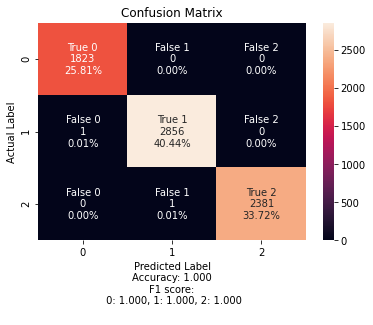

In [26]:
y_preds = log_reg.predict(X_test_std)
cf_matrix = confusion_matrix(y_test, y_preds)
plot_stats(cf_matrix, y_train, y_preds_tr, title='Confusion Matrix')

print('For testing data with L1 regularization: \n', classification_report(y_test, y_preds))

Text(0.5, 0, 'Probability')

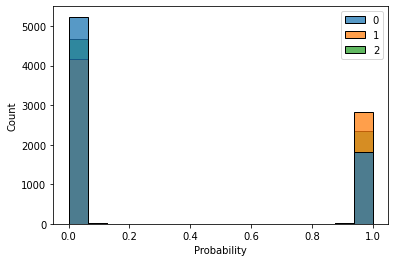

In [27]:
predicted_prob_test = log_reg.predict_proba(X_test_std)
plt.figure()
sns.histplot(predicted_prob_test)
plt.xlabel('Probability')

In [28]:
y_test.value_counts()

CylStatus
1            2857
2            2382
0            1823
dtype: int64

(7062,)
(7062,)
(7062,)


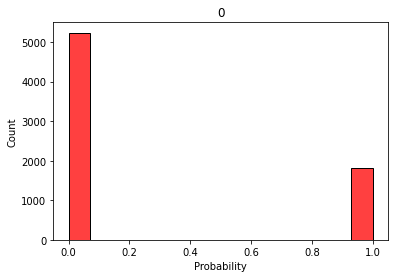

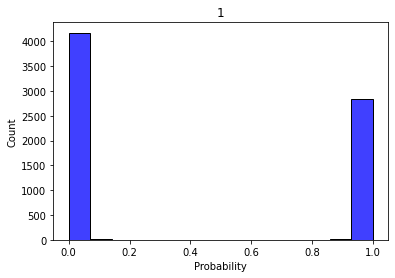

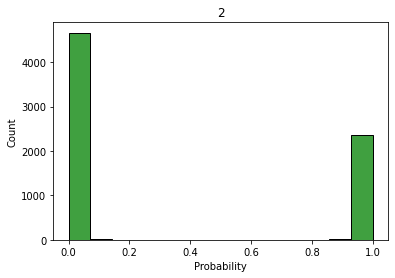

In [30]:
for cls, c in zip([0,1,2],['r','b','g']):
    plt.figure()
    plt.title(cls)
    print(predicted_prob_test[:,cls].shape)
    sns.histplot(predicted_prob_test[:,cls],color=c)
    plt.xlabel('Probability')

In [49]:
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        d = cyl_1_data_remove_FF_HF.loc[find_data_mismatch(y_test, y_preds, 
                                                           pred_label=preds, 
                                                           actual_label=actual)][FF_COLS+OUTPUT_COLS+CAT_COLS+COMMON_COLS]
        if not d.empty: 
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)
            print('-'*100)

Predicted: 0 but actual: 1


FF      HF  CylStatus  CylStatusPrev  CylStatusNext       MAF  \
23416  0.8  0.6667          1              2              2  6.047587   

           NetTQ     IntCam    ExhCam          RPM  
23416  32.554933  38.473721  8.280695  1553.536956

----------------------------------------------------------------------------------------------------
Predicted: 1 but actual: 2


FF   HF  CylStatus  CylStatusPrev  CylStatusNext        MAF  \
14114  0.6667  0.5          2              0              1  17.923079   

            NetTQ     IntCam    ExhCam          RPM  
14114  100.051966  43.071614  12.22963  2026.234751

----------------------------------------------------------------------------------------------------


In [268]:
non_zero_coeff_features = {}
for i, coeffs in enumerate(log_reg.coef_):
    print('-'*100)
    print('Non-zero coeffs for class: ', i)
    a=pd.Series(coeffs, index=X_train_std.columns)
    non_zero_coeff_features[i] = (a[~(a==0)].index.values,a[~(a==0)])
    print(a[~(a==0)].index.values)

----------------------------------------------------------------------------------------------------
Non-zero coeffs for class:  0
['MAF' 'IntCam' 'CrkAccel_Compress_120' 'CrkAccel_Compress_150'
 'CrkAccel_Expansion_60' 'CrkAccel_Expansion_90' 'CrkAccel_Expansion_150'
 'CrkAccel_Expansion_180']
----------------------------------------------------------------------------------------------------
Non-zero coeffs for class:  1
['ExhCam' 'CrkAccel_Compress_60' 'CrkAccel_Expansion_120'
 'CrkAccel_Intake_150' 'MAP_Intake_90' 'CylStatusPrev_2' 'CylStatusPrev_1'
 'const' 'CylStatusNext_1']
----------------------------------------------------------------------------------------------------
Non-zero coeffs for class:  2
['MAF' 'NetTQ' 'IntCam' 'ExhCam' 'CrkAccel_Compress_30'
 'CrkAccel_Compress_120' 'CrkAccel_Compress_150' 'CrkAccel_Expansion_30'
 'CrkAccel_Expansion_60' 'CrkAccel_Expansion_90' 'CrkAccel_Expansion_120'
 'CrkAccel_Expansion_150' 'CrkAccel_Intake_60' 'MAP_Intake_30'
 'MAP_Intake_60

In [ ]:
# indexing to find the right class scores: scores[np.arange(10),classes]

## Analyze the mismatch train and test data

In [86]:
indices = []
for preds in [0,1,2]:
    for actual in [0,1,2]:
        if preds == actual: continue
        
        idx = find_data_mismatch(y_test.append(y_train), 
                                     np.append(y_preds, y_preds_tr), 
                                     pred_label=preds, 
                                     actual_label=actual)
        d = all_cyl_1_data.loc[idx][FF_COLS+OUTPUT_COLS+FILE_COLS+COMMON_COLS]
        if not d.empty: 
            print('Predicted: {} but actual: {}'.format(preds, actual))
            display(d)
            print('-'*100)
        
        indices.extend(idx)

Predicted: 0 but actual: 1


FF      HF  CylStatus      FileName       MAF      NetTQ     IntCam  \
23416  0.8  0.6667          1  TA20060_A274  6.047587  32.554933  38.473721   

         ExhCam          RPM  
23416  8.280695  1553.536956

----------------------------------------------------------------------------------------------------
Predicted: 1 but actual: 2


FF   HF  CylStatus      FileName        MAF       NetTQ     IntCam  \
14114  0.6667  0.5          2  TA20060_A216  17.923079  100.051966  43.071614   
38476  0.6667  0.5          2  TA20060_A384   7.179331   31.358893  10.022538   

          ExhCam          RPM  
14114  12.229630  2026.234751  
38476   9.428412  1986.486263

----------------------------------------------------------------------------------------------------
Predicted: 2 but actual: 1


FF   HF  CylStatus      FileName        MAF       NetTQ     IntCam  \
27711  0.8  0.0          1  TA20060_A310  18.414484  120.650792  28.773483   

          ExhCam          RPM  
27711  12.465637  1472.045397

----------------------------------------------------------------------------------------------------


In [155]:
data_to_analyze=X_train_std.append(X_test_std).loc[indices]
weights = log_reg.coef_.T
scores = data_to_analyze @ weights
display('Unnormalized raw scores: ',scores)

'Unnormalized raw scores: '

0          1          2
23416  16.729540  16.077996   3.284647
14114 -27.621236   8.976465   8.052505
38476   2.850527  14.300760  14.300330
27711 -38.142304   8.034965   8.621951

In [141]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [173]:
probs_alldata=softmax(scores.T)
display('Probability scores: ',round(probs_alldata.T, ndigits=5))

'Probability scores: '

0        1        2
23416  0.65736  0.34264  0.00000
14114  0.00000  0.71585  0.28415
38476  0.00001  0.50010  0.49989
27711  0.00000  0.35733  0.64267

### For the points above, compare with the all the data for each case

**FF=2/3 and HF=1/2; Predicted=1;Actual=2**

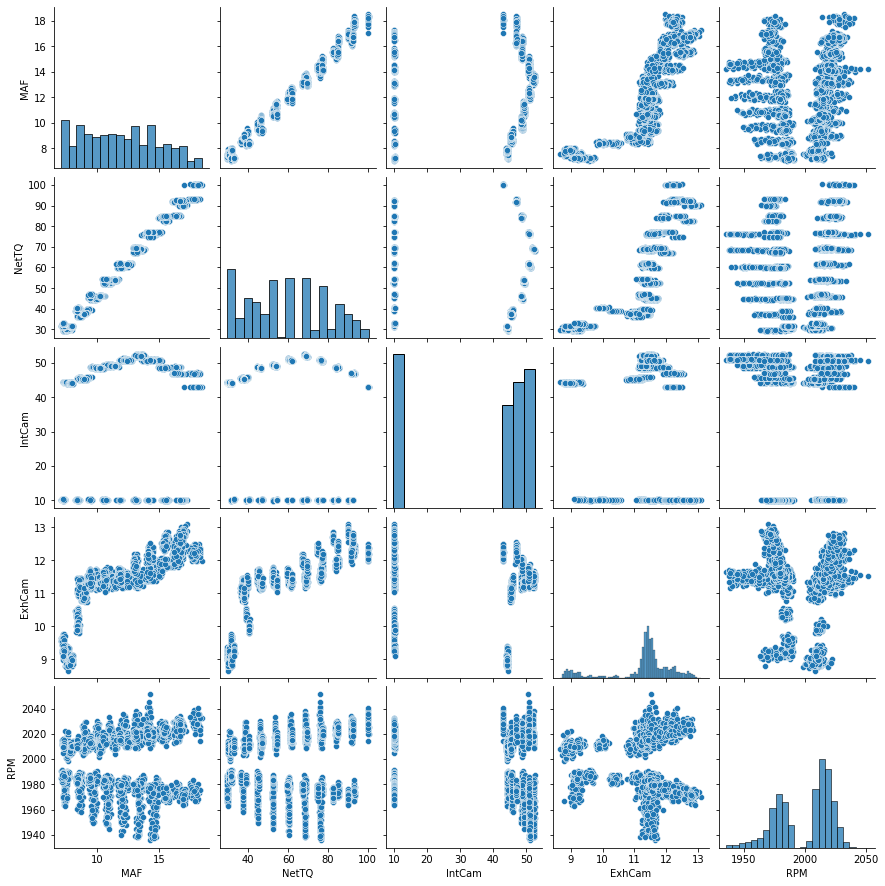

In [206]:
sns.pairplot(all_cyl_1_data[(np.isclose(all_cyl_1_data['FF'],0.6667)) & (np.isclose(all_cyl_1_data['HF'],0.5)) & 
                            (all_cyl_1_data['CylStatus']==2)][COMMON_COLS], corner)

In [246]:
data_for_this = all_cyl_1_data[(np.isclose(all_cyl_1_data['FF'],0.6667)) & (np.isclose(all_cyl_1_data['HF'],0.5)) & 
                               (all_cyl_1_data['CylStatus']==2)]

ActiveCylID  CylStatusPrev  CylStatusNext  CylStatus  MAP_Intake_30  \
9139             1              1              0          2      61.086998   
9142             1              1              0          2      61.086998   
9145             1              1              0          2      61.086998   
9148             1              1              0          2      61.086998   
9151             1              1              0          2      61.086998   
...            ...            ...            ...        ...            ...   
40321            1              0              1          2      59.483759   
40324            1              0              1          2      58.820436   
40327            1              0              1          2      58.820436   
40330            1              0              1          2      58.820436   
40333            1              0              1          2      59.152098   

       MAP_Intake_60  MAP_Intake_90  MAP_Intake_120  MAP_Intake_150  \
9139       59.761370      56.115892       53.796043       53.133229   
9142       58.767149      57.110113       54.127450       53.464636   
9145       59.761370      56.115892       54.458857       53.133229   
9148       58.435742      56.778706       53.796043       53.133229   
9151       59.098556      56.115892       54.127450       53.464636   
...              ...            ...             ...             ...   
40321      56.830466      55.172157       51.855540       51.523878   
40324      56.498804      55.172157       51.855540       51.523878   
40327      56.830466      53.845510       51.855540       51.192217   
40330      56.498804      53.845510       52.187202       51.192217   
40333      56.498804      54.177172       52.187202       51.192217   

       MAP_Intake_180  ...  CrkAccel_Compress_120  CrkAccel_Compress_150  \
9139        54.127450  ...            1177.050989            3224.742613   
9142        54.127450  ...            2993.242583            5386.616174   
9145        54.127450  ...              99.437375            3133.972337   
9148        54.127450  ...            2562.639095            5528.617055   
9151        54.127450  ...            2731.903711            2438.962434   
...               ...  ...                    ...                    ...   
40321       51.523878  ...           -6810.184290           -3249.889770   
40324       51.855540  ...           -7072.538367           -1929.536700   
40327       51.523878  ...           -6715.722236           -1957.251553   
40330       51.523878  ...           -6663.749262            -150.256097   
40333       51.523878  ...           -6645.454960             -47.636324   

       CrkAccel_Compress_180  CrkAccel_Expansion_30  CrkAccel_Expansion_60  \
9139             4094.040986            3539.056400            3289.888807   
9142             6048.384581            6787.243947            6611.023480   
9145             4627.812993            2306.112380            3115.007655   
9148             6507.026205            6789.019053            6702.851522   
9151             3837.110087            5872.114435            6704.771538   
...                      ...                    ...                    ...   
40321            1463.835214            3985.033168            4960.498845   
40324            2102.984239            3594.089746            4530.426612   
40327            2768.928711            3825.628660            4756.970714   
40330            2781.014912            4652.698469            4799.672030   
40333            1776.321691            4967.588131            6031.813283   

       CrkAccel_Expansion_90  CrkAccel_Expansion_120  CrkAccel_Expansion_150  \
9139             6213.402688             3975.006222              896.550378   
9142             6738.431443             3583.618326             -299.007421   
9145             6967.639504             4658.151255              823.455640   
9148             7212.278327             2721.5

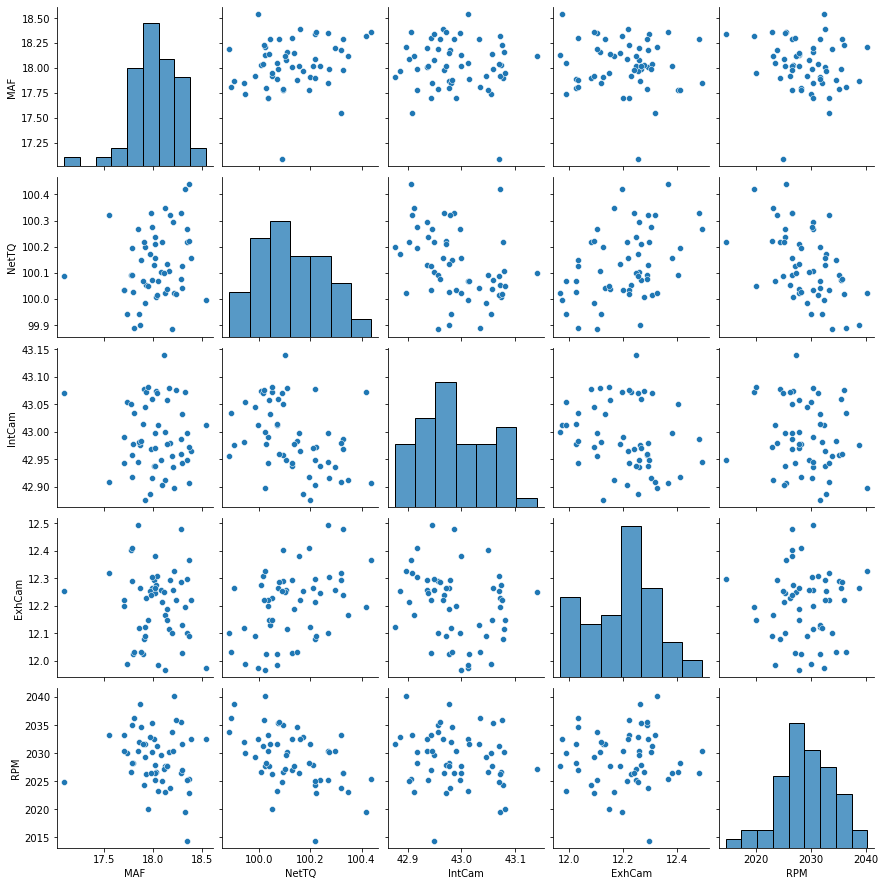

In [247]:
data_for_this_file_A216 = data_for_this[data_for_this.FileName=='TA20060_A216']
sns.pairplot(data_for_this_file_A216[COMMON_COLS])

In [254]:
data_for_this_file_A216[['ExhCam', 'CrkAccel_Compress_60','CrkAccel_Expansion_120', 'MAP_Intake_90', 
                         'CrkAccel_Intake_150']+CAT_COLS]

ExhCam  CrkAccel_Compress_60  CrkAccel_Expansion_120  MAP_Intake_90  \
14033  12.194414         -12428.267079             8040.424542     112.217970   
14036  12.265466         -13578.799017             7037.231824     112.549632   
14039  12.293098         -14382.271147             3946.634535     112.549632   
14042  12.166168         -15188.753045             4447.613364     112.549632   
14045  12.367475         -12756.012112             6619.884660     113.544617   
14048  11.989217         -14147.976511             4238.835618     113.212955   
14051  12.115765         -14078.711903             4634.576666     112.881293   
14054  12.257876         -13925.940947             5120.829607     112.881293   
14057  12.200349         -13648.151632             5876.750654     112.549632   
14060  12.124837         -14090.373308             4265.084533     112.217970   
14063  12.480761         -13685.836014             5052.527183     112.881293   
14066  12.079157         -13815.311808             4497.461394     112.881293   
14069  12.132358         -13677.844395             4141.438165     112.549632   
14072  12.254704         -14222.146583             7099.520747     112.549632   
14075  12.275900         -14309.450311             7520.721527     112.217970   
14078  11.966440         -13090.673923             7492.737995     112.217970   
14081  12.149952         -14264.121667             4623.876161     112.881293   
14084  12.030625         -14013.484965             3962.453128     112.881293   
14087  12.246516         -13205.348411             7689.467007     112.881293   
14090  12.101494         -13207.151373             4665.307092     112.881293   
14093  12.307049         -13571.989835             5500.068334     112.549632   
14096  11.973758         -14039.782440             4387.046744     112.549632   
14099  12.402605         -13772.793628             4694.131009     112.549632   
14102  12.090257         -13632.259861             3941.816001     112.549632   
14105  12.258742         -14219.505770             4574.216742     112.549632   
14108  12.214051         -13330.343083             4983.707062     112.549632   
14111  12.289070         -13854.062451             6412.457592     112.549632   
14114  12.229630         -13680.463375             7333.752247     112.549632   
14117  12.493336         -13741.747649             4151.021306     112.881293   
14120  12.102049         -14377.339804             3973.788567     112.549632   
14123  12.297451         -13169.945861             8633.426208     112.881293   
14126  12.293848         -12610.117797             7501.441740     113.876278   
14129  12.263736         -14090.511267             3280.980286     113.544617   
14132  12.249665         -14267.332168             5121.984118     112.549632   
14135  12.303491         -12944.743303             3833.411986     112.549632   
14138  12.325441         -15718.715303             6712.409190     112.881293   
14141  12.380536         -14567.709338             5005.014495     112.549632   
14144  11.986278         -13262.688038             4446.376026     112.881293   
14147  12.118609         -13473.733518             3922.486676     112.549632   
14150  12.025157         -14130.451076             4640.912479     112.549632   
14153  12.240196         -13438.756948             6380.302505     112.881293   
14156  12.222607         -13637.225187             3588.136843     112.549632   
14159  12.219914         -14353.843660             4543.358500     112.549632   
14162  12.147864         -13339.495170             5197.630436     112.881293   
14165  12.024498         -13252.539816             4125.170764     112.881293   
14168  12.287531         -14352.370304             4235.535779     112.549632   
14171  12.090359         -14918.664521             4924.877990     112.881293   
14174  12.033494         -13483.153725             5278.358843     112.881293   
14177  12.033954         -14144.421945   

In [282]:
data_for_this_file_A216

ActiveCylID  CylStatusPrev  CylStatusNext  CylStatus  MAP_Intake_30  \
14033            1              0              1          2     118.851204   
14036            1              0              1          2     119.846189   
14039            1              0              1          2     120.509513   
14042            1              0              1          2     122.499483   
14045            1              0              1          2     122.499483   
14048            1              0              1          2     122.499483   
14051            1              0              1          2     121.172836   
14054            1              0              1          2     119.846189   
14057            1              0              1          2     120.177851   
14060            1              0              1          2     120.841174   
14063            1              0              1          2     121.504498   
14066            1              0              1          2     122.499483   
14069            1              0              1          2     122.831144   
14072            1              0              1          2     120.509513   
14075            1              0              1          2     119.182866   
14078            1              0              1          2     119.514527   
14081            1              0              1          2     120.177851   
14084            1              0              1          2     122.499483   
14087            1              0              1          2     122.167821   
14090            1              0              1          2     122.499483   
14093            1              0              1          2     122.167821   
14096            1              0              1          2     121.504498   
14099            1              0              1          2     120.841174   
14102            1              0              1          2     122.167821   
14105            1              0              1          2     122.167821   
14108            1              0              1          2     121.172836   
14111            1              0              1          2     120.177851   
14114            1              0              1          2     119.182866   
14117            1              0              1          2     119.846189   
14120            1              0              1          2     122.499483   
14123            1              0              1          2     122.831144   
14126            1              0              1          2     118.851204   
14129            1              0              1          2     122.499483   
14132            1              0              1          2     122.167821   
14135            1              0              1          2     121.504498   
14138            1              0              1          2     121.172836   
14141            1              0              1          2     120.509513   
14144            1              0              1          2     121.836159   
14147            1              0              1          2     122.831144   
14150            1              0              1          2     123.162806   
14153            1              0              1          2     122.167821   
14156            1              0              1          2     123.162806   
14159            1              0              1          2     122.167821   
14162            1              0              1          2     121.172836   
14165            1              0              1          2     122.831144   
14168            1              0              1          2     121.836159   
14171            1              0              1          2     120.177851   
14174            1              0              1          2     120.177851   
14177            1              0              1          2     120.177851   
14180            1              0              1          2     119.846189   
14183            1           

In [273]:
data_for_this_file_A216[MAP_COLS].corr()

MAP_Intake_30  MAP_Intake_60  MAP_Intake_90  MAP_Intake_120  \
MAP_Intake_30        1.000000      -0.075266       0.149618       -0.003733   
MAP_Intake_60       -0.075266       1.000000       0.478834        0.238613   
MAP_Intake_90        0.149618       0.478834       1.000000        0.362960   
MAP_Intake_120      -0.003733       0.238613       0.362960        1.000000   
MAP_Intake_150      -0.665810      -0.059763      -0.421843       -0.125802   
MAP_Intake_180      -0.508051       0.008467      -0.093488        0.051460   

                MAP_Intake_150  MAP_Intake_180  
MAP_Intake_30        -0.665810       -0.508051  
MAP_Intake_60        -0.059763        0.008467  
MAP_Intake_90        -0.421843       -0.093488  
MAP_Intake_120       -0.125802        0.051460  
MAP_Intake_150        1.000000        0.299258  
MAP_Intake_180        0.299258        1.000000

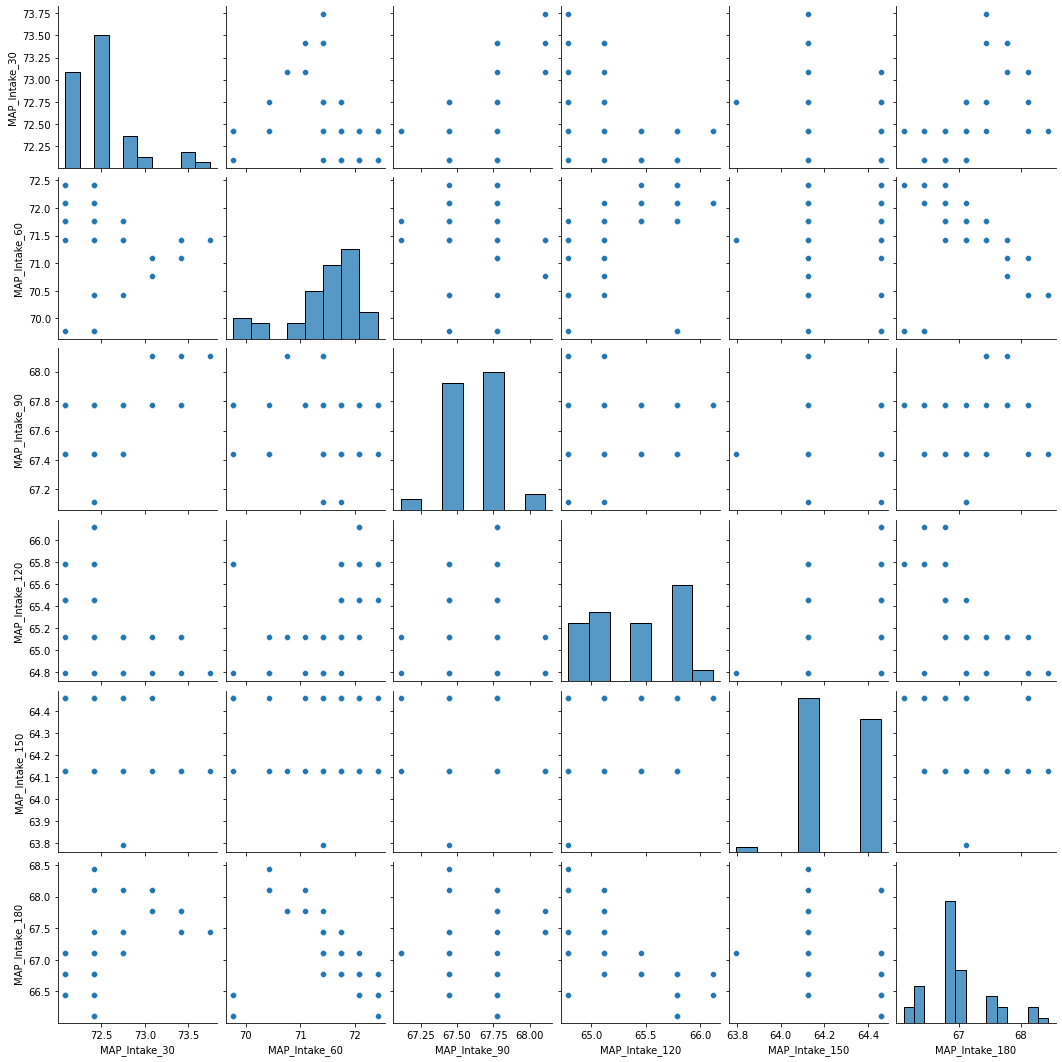

In [281]:
sns.pairplot(data_for_this[data_for_this.FileName=='TA20060_A208'][MAP_COLS])

In [279]:
data_for_this[data_for_this.FileName=='TA20060_A208'][MAP_COLS].corr()

MAP_Intake_30  MAP_Intake_60  MAP_Intake_90  MAP_Intake_120  \
MAP_Intake_30        1.000000      -0.265105       0.482960       -0.502895   
MAP_Intake_60       -0.265105       1.000000      -0.057503        0.366121   
MAP_Intake_90        0.482960      -0.057503       1.000000        0.163141   
MAP_Intake_120      -0.502895       0.366121       0.163141        1.000000   
MAP_Intake_150      -0.240487      -0.033995      -0.004745        0.246184   
MAP_Intake_180       0.570619      -0.264908       0.018096       -0.700650   

                MAP_Intake_150  MAP_Intake_180  
MAP_Intake_30        -0.240487        0.570619  
MAP_Intake_60        -0.033995       -0.264908  
MAP_Intake_90        -0.004745        0.018096  
MAP_Intake_120        0.246184       -0.700650  
MAP_Intake_150        1.000000       -0.232196  
MAP_Intake_180       -0.232196        1.000000

In [280]:
data_for_this[data_for_this.FileName=='TA20060_A208'][MAP_COLS].describe()

MAP_Intake_30  MAP_Intake_60  MAP_Intake_90  MAP_Intake_120  \
count      55.000000      55.000000      55.000000       55.000000   
mean       72.448717      71.604487      67.624546       65.375277   
std         0.389681       0.704481       0.219426        0.403502   
min        72.086904      69.765272      67.111978       64.790346   
25%        72.086904      71.423581      67.443640       65.122008   
50%        72.418566      71.755242      67.775302       65.453670   
75%        72.418566      72.086904      67.775302       65.785332   
max        73.745212      72.418566      68.106964       66.116993   

       MAP_Intake_150  MAP_Intake_180  
count       55.000000       55.000000  
mean        64.271748       66.979314  
std          0.177847        0.513015  
min         63.795361       66.116993  
25%         64.127023       66.780317  
50%         64.127023       66.780317  
75%         64.458685       67.111978  
max         64.458685       68.438625

In [263]:
data_for_this_file_A216.describe()[CACOMPRESS_COLS+CAEXPANSION_COLS+CAINTAKE_COLS]

CrkAccel_Compress_30  CrkAccel_Compress_60  CrkAccel_Compress_90  \
count             55.000000             55.000000             55.000000   
mean          -10983.102196         -13821.620841         -14439.489036   
std              919.794571            598.690810            461.073856   
min           -12425.655795         -15718.715303         -15464.827210   
25%           -11723.084801         -14179.455983         -14750.846009   
50%           -11039.648542         -13815.311808         -14386.155189   
75%           -10250.909170         -13456.245233         -14157.561258   
max            -9021.928017         -12428.267079         -13211.185828   

       CrkAccel_Compress_120  CrkAccel_Compress_150  CrkAccel_Compress_180  \
count              55.000000              55.000000              55.000000   
mean           -13317.225756           -4760.685144            2300.613615   
std               473.578550             760.686092            1593.810898   
min            -14221.479781           -7077.739496            -589.406242   
25%            -13648.049116           -5175.586644            1079.823995   
50%            -13349.756200           -4915.718105            1805.036259   
75%            -13033.994010           -4503.590448            3255.064879   
max            -12277.701324           -2519.407867            5354.183877   

       CrkAccel_Expansion_30  CrkAccel_Expansion_60  CrkAccel_Expansion_90  \
count              55.000000              55.000000              55.000000   
mean             6544.714729           11888.711356           14985.038825   
std              1250.834400             611.771541             504.090330   
min              5112.419028           10019.480840           13820.014792   
25%              5840.680867           11522.664988           14649.543895   
50%              6170.915197           11884.435718           15042.434674   
75%              6466.273282           12223.175840           15384.101402   
max             10245.465189           13309.962458           15960.416104   

       CrkAccel_Expansion_120  CrkAccel_Expansion_150  CrkAccel_Expansion_180  \
count               55.000000               55.000000               55.000000   
mean              5130.116098             6641.850492             6470.566035   
std               1324.273374             1019.856712             1169.044311   
min               3280.980286             3768.924271             3465.303705   
25%               4146.229736             6137.770212             5938.175923   
50%               4640.912479             6742.849932             6724.870457   
75%               5688.409494             7408.458754             7302.254030   
max               8633.426208             9335.450340             8167.237054   

       CrkAccel_Intake_30  CrkAccel_Intake_60  CrkAccel_Intake_90  \
count           55.000000           55.000000           55.000000   
mean          3110.018344         3896.106241         5786.845134   
std           1401.687354         1042.906850          526.550139   
min            667.558435          901.878949         4681.068080   
25%           1646.904630         3121.130157         5430.472618   
50%           3707.350365         4002.766738         5799.100731   
75%           4174.561456         4758.975426         6033.692818   
max           5314.679325         5526.257513         7498.659555   

       CrkAccel_Intake_120  CrkAccel_Intake_150  CrkAccel_Intake_180  
count            55.000000            55.000000            55.000000  
mean           2535.947037         -2816.658548         -6019.674113  
std            1309.001705           618.683947          1643.696665  
min            -496.201861         -4145.850913         -8646.587588  
25%            2234.211068         -3296.696665         -7353.662244  
50%            2892.009862         -2706.256447         -6597.095225  
75%            3422.242692         -2386.861563         -4198.919842  
max  

In [286]:
non_zero_coeff_features[0][1]

MAF                      -2.865355
IntCam                   -0.303777
CrkAccel_Compress_120     3.896164
CrkAccel_Compress_150     2.140705
CrkAccel_Expansion_60    -9.549633
CrkAccel_Expansion_90    -8.374321
CrkAccel_Expansion_150    3.407830
CrkAccel_Expansion_180    4.144171
dtype: float64

In [269]:
non_zero_coeff_features[1][1]

ExhCam                    -2.275217
CrkAccel_Compress_60      -1.354257
CrkAccel_Expansion_120     0.168532
CrkAccel_Intake_150        0.062882
MAP_Intake_90             -1.192309
CylStatusPrev_2            0.604170
CylStatusPrev_1           -1.008337
const                     11.641033
CylStatusNext_1           -1.652950
dtype: float64

In [270]:
non_zero_coeff_features[2][1]

MAF                        4.568088
NetTQ                      0.743339
IntCam                     6.874407
ExhCam                     0.762686
CrkAccel_Compress_30       3.660786
CrkAccel_Compress_120     -7.267451
CrkAccel_Compress_150     -1.666521
CrkAccel_Expansion_30      0.102068
CrkAccel_Expansion_60      9.839310
CrkAccel_Expansion_90      8.863993
CrkAccel_Expansion_120    -1.345193
CrkAccel_Expansion_150    -6.498667
CrkAccel_Intake_60        -0.190643
MAP_Intake_30             29.843956
MAP_Intake_60              1.005680
MAP_Intake_150           -25.397085
MAP_Intake_180           -24.258641
CylStatusNext_2            0.428823
const                     -4.230145
dtype: float64